In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
# This bit of code allows me to import modules for adjacent folders:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
cnx = sqlite3.connect('../data.db')
import numpy as np
import regex as re

In [4]:
from src.services.MinisterialDiaryService import *
ministerDataService = MinisterialDiaryDataService(cnx)
diaries_df = ministerDataService.get_diary_entries(state_filter = "NSW")
print(f"min date: {diaries_df['date'].min()}")
print(f"min date: {diaries_df['date'].max()}")


min date: 2014-03-04 00:00:00
min date: 2022-11-24 00:00:00


In [5]:
from src.services.LobbyistService import LobbyistDataService
lobbyistDataService = LobbyistDataService(cnx)
all_lobbyist_employees_df = lobbyistDataService.get_all_lobbyist_employees()
unique_lobbyist_orgs_df = lobbyistDataService.get_unique_lobbyist_abns()
unique_lobbyist_orgs_df



,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,124372096.0,The Strategic Counsel Pty Ltd,124372096,the strategic counsel
1,606084913.0,Atlas Alliance,606084913,atlas alliance
2,4625954912.0,Kurrajong Strategic Counsel,4625954912,kurrajong strategic counsel
3,11007120881.0,G.E.M. Management Pty Ltd,11007120881,gem management
4,11127557448.0,BusinessAide Pty Ltd,11127557448,businessaide
...,...,...,...,...
599,99649180898.0,Capital Integrity Group Pty Ltd,99649180898,capital integrity group
600,99718745060.0,Devlin Consulting,99718745060,devlin consulting
601,ABN56242935104,Strategic Pathways Consulting,56242935104,strategic pathways consulting
602,"ABN94064357544,ACN064357544",CPR Communications and Public Relations Pty Lt...,94064357544,cpr communications and public relations


## Duplicate Lobbyist names across organisations

Lets take a look a closer look at the lobbyist employees which is how we plan to link lobbyist organisations to the ministerial diary entries, we know there will be duplicate names across these organisations but how can we tell if they are the same person or if they are different people with a commen name?

In [6]:
unique_employees = lobbyistDataService.get_unique_employee_to_lobbyists()

unique_employees['count'] = 1
duplicate_employees = unique_employees[['lobbyist_name_clean', 'count']] \
    .groupby('lobbyist_name_clean') \
    .count() \
    .reset_index() \
    .sort_values('count', ascending = False)
duplicate_employees[duplicate_employees['count'] > 1].sort_values('count', ascending = False)

,lobbyist_name_clean,count
55,alistair nicholas,5
1537,todd hayward,4
600,ian hancock,4
158,antony anisse,4
1090,michael photios,4
...,...,...
1378,sean johnson,2
1352,samuel walker,2
287,chris fry,2
282,cathy duncan,2


So lets take a closer look at some of these people which show up in multiple lobbyist organistaions.

### Alistair Nicholas

In [7]:
# 50 shades of Alister Nicholes
def inspect_lobbyist(name):
    return unique_employees[unique_employees['lobbyist_name_clean'] == name] \
        .merge(unique_lobbyist_orgs_df, left_on='lobbyist_abn_clean', right_on='abn_clean')

inspect_lobbyist('alistair nicholas')

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,alistair nicholas,16007797793,0,1,0,0,1,16007797793.0,Allan King Consultancy,16007797793,allan king consultancy
1,alistair nicholas,47393236557,0,1,0,0,1,47393236557.0,Alistair Nicholas Consulting,47393236557,alistair nicholas consulting
2,alistair nicholas,81655939852,1,1,1,1,1,81655939852.0,Alistair Nicholas Consulting Pty Ltd,81655939852,alistair nicholas consulting
3,alistair nicholas,96004928652,0,1,0,0,1,96004928652.0,Weber Shandwick Worldwide/ Powell Tate Australia,96004928652,weber shandwick worldwide powell tate australia
4,alistair nicholas,99153936719,0,1,0,1,1,99153936719.0,Cornerstone Group,99153936719,cornerstone group


Manually taking a look at Alistair Nicholas LinkedIn Profile (https://www.linkedin.com/in/alistairnicholas/) I can see that he has most of these companies listed in his experiance i.e. previous and current employment/business ventures:

Experiance:

 - Alistair Nicholas Consulting
 - Cornerstone Group Associates
 - Powell Tate
 - Weber Shandwick

Given this I am pretty sure that all these records refere to the same person, the one true Alistair Nicholas. Will also note that he has worked as a senior adviser to government officials.

### Todd Hayward

In [8]:
inspect_lobbyist('todd hayward')

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,todd hayward,23630677673,0,1,0,0,1,23630677673.0,TG Public Affairs Pty Ltd,23630677673,tg public affairs
1,todd hayward,54609703219,0,1,0,0,1,54609703219.0,Telamon Consulting,54609703219,telamon consulting
2,todd hayward,93103996952,0,1,0,0,1,93103996952.0,Cato Counsel,93103996952,cato counsel
3,todd hayward,98643575462,0,1,0,0,1,98643575462.0,Capital Advisory Group Australia,98643575462,capital advisory group australia


Manually checking out Todd Hayward's LinkedIn Profile (https://www.linkedin.com/in/toddhayward/) this individual has some of these companies listed in his experiance.

 - Telamon Consulting Pty Ltd
 - Cato Counsel

He also has listed in his experiance that he was Minister for Environment & Climate Change, worked for Priemers office and NSW Goverment

Capital Advisory Group Australia - I can't find a profile for this business based in australia, possibly a forign company, according the ABN lookup this the entity name for this ABN is 'The Trustee for Capital Advisory Group Unit Trust', can't find any LinkedIn profile for this business name either.

### Ian Hancock

In [9]:
inspect_lobbyist('ian hancock')

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,ian hancock,26149964189,1,1,0,0,1,26149964189.0,PremierState,26149964189,premierstate
1,ian hancock,36162434031,0,1,0,0,1,36162434031.0,Capital Hill Advisory,36162434031,capital hill advisory
2,ian hancock,71619450841,1,1,1,1,1,71619450841.0,PremierNational,71619450841,premiernational
3,ian hancock,98618481824,0,1,0,0,1,98618481824.0,Clean Energy Strategies,98618481824,clean energy strategies


Now lets take a look at Ian Hancock (https://www.linkedin.com/in/ian-hancock-805a9266/), I can see all but one of these organisation on this LinkedIn profile, so again I think this is all the same person.

  - PremierNational
  - PremierState
  - Clean Energy Strategies

The only one I can't see is Capital Hill Advisory, I can see a company profile for this organisation but I don't see any Ian Hancock linked to it. But as we will see there is another lobbyist which is associated with the same lobbyist organisations as Ian including Capital Hill, and this other lobbyist (Michael Photios) does not list Capital Hill Advisory in his LinkedIn profile.

### Antony Anisse

In [10]:
inspect_lobbyist('antony anisse')

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,antony anisse,26149964189,1,1,0,0,1,26149964189.0,PremierState,26149964189,premierstate
1,antony anisse,56158689644,0,1,0,0,1,56158689644.0,Silentium,56158689644,silentium
2,antony anisse,71619450841,1,1,1,1,1,71619450841.0,PremierNational,71619450841,premiernational
3,antony anisse,78071667797,0,1,0,0,1,78071667797.0,Silk Road Commercial Pty Ltd,78071667797,silk road commercial


So I could only for one LinkedIn profile for this name (https://www.linkedin.com/in/antonyanisse), and from this I can see he has PremierNational listed in his experiance as well as experiance working in local government, I don't see these other organisations listed though.

**Silentium** - Can find much on this organisation, I'm pretty sure it is not Silentium Defence, I found the following trademark registration which has lapsed (https://www.trademarkelite.com/australia/trademark/trademark-detail/1628282/Silentium) the post code (2158) associated with this application is located in the general Hornsby Shire area which is consistent with the work history of this Antony Anisse, who was Councillor for the Hornsby Shire.

**Silk Road Commercial Pty Ltd** - Couldn't really find much on this company, apparently this guy is the director: https://www.linkedin.com/in/roborrell/, but other then that this organisation doesn't have much of a presance on LinkedIn.

Also there's this: https://www.smh.com.au/national/nsw/urbangrowth-director-quits-after-father-s-1-3m-profit-revealed-20190121-p50soh.html

### Michael Photios

In [11]:
inspect_lobbyist('michael photios')

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
0,michael photios,26149964189,1,1,0,0,1,26149964189.0,PremierState,26149964189,premierstate
1,michael photios,36162434031,0,1,0,0,1,36162434031.0,Capital Hill Advisory,36162434031,capital hill advisory
2,michael photios,71619450841,1,1,1,1,1,71619450841.0,PremierNational,71619450841,premiernational
3,michael photios,98618481824,0,1,0,0,1,98618481824.0,Clean Energy Strategies,98618481824,clean energy strategies


Michael looks pretty much identical to Ian Hancock, and I found his LinkedIn profile (https://www.linkedin.com/in/michael-photios-2a430882), and similar to Ian I can see all but one of these organisations in his employment history, which is the same organisation missing from Ian's history 'Capital Hill Advisory'.

  - PremierNational
  - PremierState
  - Clean Energy Strategies

Michael has also been a member of parliament and held many positions in the NSW government.

### Conclusion on lobbyist employees and linkage confidence score

Based on the five names I've looked at which show up across multiple organisations, these appear to be in most cases if not all the same person, however as I have describe above it is not always clear by looking at their LinkedIn profiles that this is the case, particularly with Antony Anisse, I don't see howe we could reconsile some of these cases without manually investigating.

And given that in a lot of cases at least the same name appearing in multiple organisations will actually be the same person deriving some kind of confidence score for the linkage will be problematic.

In [12]:
all_lobyist_clients_df = lobbyistDataService.get_all_lobbyist_clients()
all_lobyist_clients_df

,lobbyist_abn,name,name_clean,lobbyist_abn_clean
0,124372096.0,Aspen Medical Pty Ltd,aspen medical,124372096
1,124372096.0,BLACKMORES LIMITED,blackmores,124372096
2,124372096.0,Fresenius Kabi Australia,fresenius kabi australia,124372096
3,124372096.0,Hearing Care Industry Association,hearing care industry association,124372096
4,124372096.0,Optum Health &amp; Technology (Australia) Pty Ltd,optum health technology,124372096
...,...,...,...,...
7377,"ABN94064357544,ACN064357544",UFC,ufc,94064357544
7378,ACN140857432,Agersens,agersens,140857432
7379,ACN140857432,Online Brands Group,online brands group,140857432
7380,ACN140857432,ResourceCo,resourceco,140857432


In [13]:
from src.services.Cleaners import *
mining_data_df = pd.read_csv('../NSW_Mining_data.csv')
clean_business_name(mining_data_df, 'company')

In [14]:
def _switch_on_coma(value):
    parts = value.split(',')
    if len(parts) == 2:
        return f'{parts[1]} {parts[0]}'
    else:
        return value
switch_on_coma = np.vectorize(_switch_on_coma)

def load_donations_data():
    political_donations_df = pd.read_csv("../NSW_Donations.csv")
    remove_words = ['pty', 'ltd', 'proprietary', 'limited', 'company', '.', 'no1']
    political_donations_df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_') for c in political_donations_df.columns]
    political_donations_df["clean_donor_name"] = political_donations_df["donor_name"]
    for word in remove_words:
            political_donations_df["clean_donor_name"]  = political_donations_df["clean_donor_name"] .str.replace(word, '')

    political_donations_df["clean_donor_name"] = political_donations_df["clean_donor_name"].str.lower()
    political_donations_df['doner_name_switched'] = switch_on_coma(political_donations_df['clean_donor_name'])
    political_donations_df["amount_or_value_made"] = political_donations_df["amount_or_value_made"].str.extract('(\d*\.\d*|\d*,\d*\.\d*)', expand=False)
    political_donations_df["amount_or_value_made"] = pd.to_numeric(political_donations_df["amount_or_value_made"].str.replace(',', ''))

    political_donations_df = political_donations_df[~political_donations_df['date_donation_made'].str.startswith("Total Valid Amount", na=False)]
    political_donations_df['year'] = political_donations_df['date_donation_made'].str.extract(r'\d{1,2}\/\d{1,2}\/(\d{2,4})')
    return political_donations_df[["recipient_name","type","amount_or_value_made", "clean_donor_name","doner_name_switched", "date_donation_made", "year"]]
    # return political_donations_df

donations_data = load_donations_data()
donations_data

,recipient_name,type,amount_or_value_made,clean_donor_name,doner_name_switched,date_donation_made,year
0,"Page, Donald",Candidate,200.0,& geraldin,& geraldin,16/3/2011,2011
1,National Party of Australia - NSW,Party,90.0,& geraldin,& geraldin,14/11/2011,2011
2,National Party of Australia - NSW,Party,999.0,& geraldin,& geraldin,3/8/2011,2011
3,National Party of Australia - NSW,Party,999.0,& geraldin,& geraldin,20/6/2011,2011
5,Australian Labor Party (NSW Branch),Party,1000.0,(alp nsw) haberfield branch,(alp nsw) haberfield branch,8/9/2008,2008
...,...,...,...,...,...,...,...
43096,NaN,Candidate,1100.0,"zofrea, frank",frank zofrea,1/8/2008,2008
43098,NaN,Candidate,9500.0,"zofrea, joe",joe zofrea,1/8/2008,2008
43100,Jihad Dib,Candidate,1000.0,zreika family association inc,zreika family association inc,20/2/2015,2015
43102,Clover Margaret Moore,Candidate,3000.0,"zulaikha, abraham brian",abraham brian zulaikha,17/6/2016,2016


In [15]:
class Searcher:
    def __init__(self, employees_df, mining_data_df, clients_df, diaries_df):
        self.employee_associations = []
        self.client_associations = []
        self.mining_company_associations = []
        self.employees_df = employees_df
        self.clients_df = clients_df
        self.mining_data_df = mining_data_df
        self.link_to_lobbyist_employee_name = np.vectorize(self._link_to_lobbyist_employee_name)
        self.is_client_mining_company = np.vectorize(self._is_client_mining_company)
        self.mining_company_names = []
        self.link_to_mining_company = np.vectorize(self._link_to_mining_company)
        self.diaries_df = diaries_df

    ##############################################################
    #       Mining Companies
    ##############################################################

    # gets a list of company names
    def get_mining_company_names_clean(self):
        if len(self.mining_company_names) == 0:
            # a manual list of mining companies 
            mining_companies = [
                # http://iminco.net/queensland-mining-companies/
                'Adani Mining', 'Anglo Coal', 'BHP Billiton', 'Caledon Coal', 'Carabella Resources', 'Citigold', 'Ensham Resources',
                'Ernest Henry Mining', 'Jellinbah Group', 'New Hope Coal','Newlands Coal', 'Oaky Creek Coal','Opal Horizon','Peabody Energy',
                'Perilya Mines', 'Qcoal','Rio Tinto','Yancoal',
                # http://iminco.net/mining-companies-australia/
                'Bechtel', 'Cuesta Coal', 'Fortescue Metals','GLOUCESTER COAL','GVK Industries',
                'Hancock Prospecting', 'Tinkler', 'Newmont Corporation','OZ MINERALS' ,'Xstrata','NSW Minerals Council'
            ]
            
            mining_companies_df = pd.DataFrame({ 'company_name': mining_companies })
            
            mining_companies = mining_companies_df['company_name'].unique().tolist()

            # and from the mining leases data
            [mining_companies.append(name) for name in self.mining_data_df['company_clean'].unique() 
                if name not in mining_companies and 'deceased' not in name]

            self.mining_company_names = pd.DataFrame({ 'company_name': mining_companies})
            clean_business_name(self.mining_company_names, 'company_name')
            self.mining_company_names = self.mining_company_names['company_name_clean'].tolist()

        return self.mining_company_names

    # checks if the string value passed in is a mining company name
    # and builds up a list of client associations
    def _is_client_mining_company(self, client_name):
        mining_companies = self.get_mining_company_names_clean()
        found = [name for name in mining_companies if name in client_name or client_name in name]
        for f in found:
            self.client_associations.append({ 'client_name': client_name, 'mining_company_name': f})
        
        return len(found) > 0

    # builds up a list of client associations to mining companies then returns
    # a dataframe with mining companies joined to lobbyist clients
    def get_client_associations_df(self):
        self.is_client_mining_company(self.clients_df['name_clean'])
        mining_associations_df = pd.DataFrame(self.client_associations)
        return mining_associations_df.merge(self.clients_df, left_on = 'client_name', right_on = 'name_clean')

    # checks if the string value passed in contains a mining company name
    # and builds up a list on mining company associations to the ministerial diaries
    def _link_to_mining_company(self, organisation_individual, id):
        mining_companies = self.get_mining_company_names_clean()
        found = [name for name in mining_companies if name in organisation_individual]
        [self.mining_company_associations.append({ 'ministerial_diary_id': id, 'company_name': name, 'organisation_individual': organisation_individual}) 
            for name in found]
        return len(found) > 0

    # goes through the list of mining company associations to ministerial diary
    # entries and returns a data from of mining companies joined to ministerial diaries
    def get_mining_company_associations_df(self):

        # check that the name is surrounded by word boundries
        evaluate = lambda n, o : len(re.findall(r'\b' + n + r'\b', o)) > 0
        for a in self.mining_company_associations:
            a['match'] = evaluate(a['company_name'], a['organisation_individual'])
        
        mining_company_associations_df = pd.DataFrame(self.mining_company_associations)
        mining_company_associations_df = mining_company_associations_df[mining_company_associations_df['match'] == True]
        return mining_company_associations_df.merge(self.diaries_df[['id', 'portfolio_clean']], left_on = 'ministerial_diary_id', right_on = 'id')


    ##############################################################
    #       Lobbyist Employees
    ##############################################################

    # checks if the string value passed in contains the name of a lobbyist employee
    # build up a list of employee associations
    def _link_to_lobbyist_employee_name(self, organisation_individual, id):
        employee_names = self.employees_df['lobbyist_name_clean'].unique()
        found = [name for name in employee_names if name in organisation_individual]
        [self.employee_associations.append({ 'ministerial_diary_id': id, 'lobbyist_name': name, 'organisation_individual': organisation_individual}) 
            for name in found]
        return len(found) > 0

    # performs further filtering of the employee associations ensuring
    # names a surrounded by word boundries then returns as dataframe
    def get_employee_associations(self):  

        # check that the name is surrounded by word boundries
        evaluate = lambda n, o : len(re.findall(r'\b' + n + r'\b', o)) > 0
        for a in self.employee_associations:
            a['match'] = evaluate(a['lobbyist_name'], a['organisation_individual'])

        employee_associations_df = pd.DataFrame(self.employee_associations)
        employee_associations_df = employee_associations_df[employee_associations_df['match'] == True]
        return employee_associations_df

    # joins the employee associations  with the employee dataframe and diaries dataframe
    def get_associated_employees_df(self):
        associations_df = self.get_employee_associations()
        local_employees_df = self.employees_df[['title', 'lobbyist_name_clean', 'lobbyist_abn_clean']]
        result_df = associations_df.merge(
            local_employees_df
            , left_on = 'lobbyist_name'
            , right_on = 'lobbyist_name_clean'
        ).merge(self.diaries_df[['id', 'portfolio_clean']], left_on = 'ministerial_diary_id', right_on = 'id')
        return result_df

    def get_employees_linked_to_diaries(self):
        search.link_to_lobbyist_employee_name(diaries_df['organisation_individual_clean'], diaries_df['id'])
        associated = self.get_associated_employees_df()
        associated = associated.merge(unique_lobbyist_orgs_df, left_on = 'lobbyist_abn_clean', right_on = 'abn_clean')[[
            'ministerial_diary_id', 'lobbyist_name_clean', 'title', 'portfolio_clean', 'lobbyist_org_name', 'lobbyist_abn_clean']].drop_duplicates()
        return associated

    def get_mining_companies_linked_to_diaries_via_lobbyists(self):
        associated = self.get_employees_linked_to_diaries()
        unique_lobbyist_orgs_df = lobbyistDataService.get_unique_lobbyist_abns()
        mining_company_associations = search.get_client_associations_df()
        mining_company_associations = mining_company_associations.merge(unique_lobbyist_orgs_df, left_on = 'lobbyist_abn_clean', right_on = 'abn_clean')[[
            'client_name', 'mining_company_name', 'name', 'lobbyist_abn_clean' #, 'lobbyist_org_name'
            ]].drop_duplicates()
        mining_company_associations = mining_company_associations.merge(associated, left_on = 'lobbyist_abn_clean', right_on = 'lobbyist_abn_clean').drop_duplicates()
        return mining_company_associations

    def get_mining_companies_linked_to_diaries(self):
        search.link_to_mining_company(self.diaries_df['organisation_individual_clean'], self.diaries_df['id'])
        mining_associations_df = self.get_mining_company_associations_df()
        return mining_associations_df


search = Searcher(all_lobbyist_employees_df, mining_data_df, all_lobyist_clients_df, diaries_df)

In [16]:
associated = search.get_employees_linked_to_diaries()
associated

,ministerial_diary_id,lobbyist_name_clean,title,portfolio_clean,lobbyist_org_name,lobbyist_abn_clean
0,241,brian tyson,Managing Partner,minister for sport multiculturalism seniors an...,SEC Newgate Pty Limited,38162366056
1,1110,brian tyson,Managing Partner,minister for sport multiculturalism seniors an...,SEC Newgate Pty Limited,38162366056
2,1152,brian tyson,Managing Partner,minister for sport multiculturalism seniors an...,SEC Newgate Pty Limited,38162366056
3,1179,brian tyson,Managing Partner,minister for sport multiculturalism seniors an...,SEC Newgate Pty Limited,38162366056
4,1301,brian tyson,Managing Partner,minister for jobs investment tourism western s...,SEC Newgate Pty Limited,38162366056
...,...,...,...,...,...,...
383,41060,peter wilkinson,Chair,minister for health and medical research,Wilkinson Butler,95164204111
384,41060,peter wilkinson,Chairman,minister for health and medical research,Wilkinson Butler,95164204111
385,43142,mitch tanner,Senior Associate Policy and Strategy,minister for health and medical research,Cornerstone Group,99153936719
386,43142,mitch tanner,Senior Associate- Policy and Strategy,minister for health and medical research,Cornerstone Group,99153936719


In [17]:
mining_company_associations = search.get_mining_companies_linked_to_diaries_via_lobbyists()
mining_company_associations

,client_name,mining_company_name,name,lobbyist_abn_clean,ministerial_diary_id,lobbyist_name_clean,title,portfolio_clean,lobbyist_org_name
0,rio tinto,rio tinto,Rio Tinto Ltd,15351458331,35973,paul chamberlin,Partner,deputy premier minister for regional nsw minis...,Endeavour Consulting Group Pty Ltd
1,rio tinto,rio tinto,Rio Tinto Ltd,66619642858,7025,simon ward,Associate Director Government Relations,minister for agriculture and minister for west...,Regen Strategic
2,santos,santos nsw,Santos,20098705403,14430,armon hicks,Senior Advisor,deputy premier and minister for regional nsw i...,Australian Public Affairs
3,santos,santos nsw,Santos Limited,22003287643,14430,armon hicks,Managing Partner Australia/NZ,deputy premier and minister for regional nsw i...,Kreab
4,santos,santos nsw,SANTOS LIMITED,65140067287,602,katrina hodgkinson,Director,minister for local government,Barton Deakin Pty Limited
...,...,...,...,...,...,...,...,...,...
9474,boral recycling,boral,BORAL RECYCLING PTY LIMITED,92715851492,42493,kerry chikarovski,Director,minister for family community services social ...,Chikarovski & Associates Pty Ltd
9475,afford,hughes william trafford,AFFORD,95164204111,41060,peter wilkinson,Chair,minister for health and medical research,Wilkinson Butler
9476,afford,hughes william trafford,AFFORD,95164204111,41060,peter wilkinson,Chairman,minister for health and medical research,Wilkinson Butler
9477,csr building products,csr building products,CSR BUILDING PRODUCTS LIMITED,99153936719,43142,mitch tanner,Senior Associate Policy and Strategy,minister for health and medical research,Cornerstone Group


In [18]:
mining_associations_df = search.get_mining_companies_linked_to_diaries()
mining_associations_df

,ministerial_diary_id,company_name,organisation_individual,match,id,portfolio_clean
0,324,rio tinto,rio tinto,True,324,minister for energy and environment
1,327,nsw minerals council,nsw minerals council,True,327,minister for energy and environment
2,364,nsw minerals council,nsw minerals council,True,364,minister for energy and environment
3,397,rio tinto,rio tinto,True,397,minister for roads maritime and freight
4,662,bhp billiton,bhp billiton,True,662,minister for local government
...,...,...,...,...,...,...
232,42816,nsw minerals council,nsw minerals council,True,42816,minister for planning
233,42817,peabody energy,peabody energy australia,True,42817,minister for planning
234,42818,rio tinto,rio tinto,True,42818,minister for planning
235,42820,illawarra coal holdings,south32 illawarra coal holdings,True,42820,minister for planning


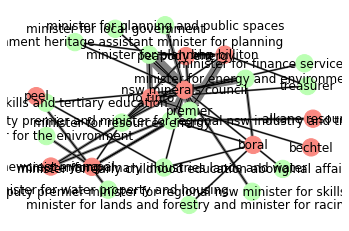

In [19]:

m_df = mining_associations_df[['company_name', 'portfolio_clean', 'ministerial_diary_id']].groupby(['company_name', 'portfolio_clean']).count().reset_index()
m_df.columns = ['company_name', 'portfolio_clean', 'weight']
m_df = m_df[m_df['weight'] > 1]


import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (21,13)
G = nx.Graph()

color_map = []
color_map += ['#bbffb3' for l in m_df['portfolio_clean'].unique()]
G.add_nodes_from(m_df['portfolio_clean'])
color_map += ['#fa8a82' for l in m_df['company_name'].unique()]
G.add_nodes_from(m_df['company_name'])
G.add_weighted_edges_from(m_df[['company_name', 'portfolio_clean', 'weight']].itertuples(index=False, name=None))
pos = nx.spring_layout(G, k=2, iterations=50)

all_weights = []
for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight'])

unique_weights = list(set(all_weights))
for weight in unique_weights:
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='grey')

nx.draw(G, cmap = plt.get_cmap('jet'), with_labels=True, node_color=color_map, pos=pos)
plt.show()


In [20]:
m_df

,company_name,portfolio_clean,weight
1,alkane resources,deputy premier and minister for regional nsw i...,3
15,bechtel,premier,2
20,bhp billiton,minister for planning,3
21,bhp billiton,minister for resources energy,2
23,bhp billiton,premier,9
24,bhp billiton,treasurer,2
26,boral,deputy premier and minister for regional nsw i...,2
28,boral,minister for energy and environment,3
30,boral,minister for lands and forestry and minister f...,2
33,boral,minister for primary industries lands and water,2


<AxesSubplot:xlabel='company_name'>

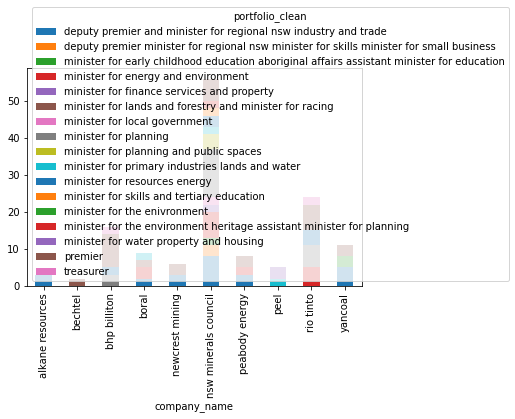

In [21]:
pd.pivot_table(m_df, columns=['portfolio_clean'], values='weight', index='company_name').plot.bar(stacked=True)

 - network graph of Lobbyists meetings with ministers
 - network graph of Mining companies to Lobbyists
 - word cloud of notes from diaries of interactions with mining companies
 - word cloud of notes from diaries of interactions with lobbyists

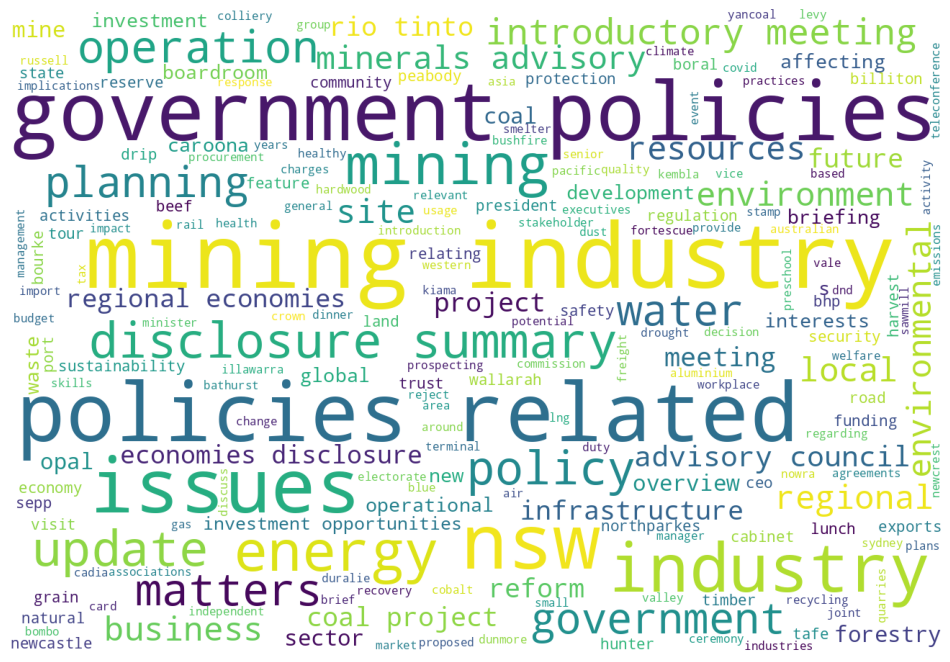

In [22]:
from wordcloud import WordCloud, STOPWORDS
linked_diaries_df = mining_associations_df.merge(diaries_df, left_on = 'ministerial_diary_id', right_on = 'id')

comment_words = ''
stopwords = set(STOPWORDS)
for val in linked_diaries_df['purpose_of_meeting'].str.lower():
    val = str(val)
    
    tokens = val.split(' ')
    out_tokens = []
    for i in range(len(tokens)):
            if tokens[i] not in ('discuss', 'discussion', 'hosted', 'status'):
                out_tokens.append(tokens[i])
    comment_words += " ".join(out_tokens)+" "

wordcloud = WordCloud(width = 1300, height = 900,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (13, 9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

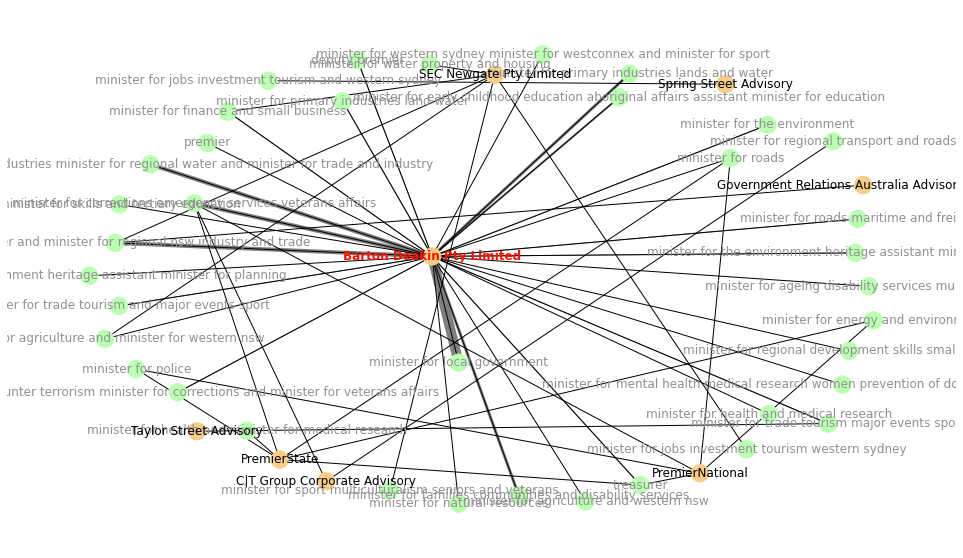

In [41]:
import math
ma_df = mining_company_associations[['name','lobbyist_org_name', 'portfolio_clean']].groupby(['lobbyist_org_name', 'portfolio_clean']).count().reset_index()
ma_df.columns = ['lobbyist_org_name', 'portfolio_clean', 'weight']
ma_df = mining_company_associations.merge(ma_df, on=['lobbyist_org_name', 'portfolio_clean'])[['name', 'lobbyist_org_name', 'portfolio_clean', 'weight']].drop_duplicates()
ma_df = ma_df[ma_df['weight'] > 9]
ma_df['dummy_weight'] = 0

def normalize_weights(data):
    temp = ((data - np.min(data)) / (np.max(data) - np.min(data)) * 10)
    return [int(i) for i in temp]

ma_df['normalized_weight'] = normalize_weights(ma_df['weight'])
# nodes
# name 
# lobbyist_org_name
# portfolio_clean

plt.rcParams["figure.figsize"] = (17,10)
G = nx.Graph()
color_map = []
# color_map = ['orange' for l in lobbyists['lobbyist_abn_clean'].unique()]
# G.add_nodes_from(lobbyists['lobbyist_abn_clean'])
# color_map += ['blue' for l in lobbyists['lobbyist_name'].unique()]
# G.add_nodes_from(lobbyists['lobbyist_name'])
# color_map += ['green' for l in lobbyists['portfolio_clean'].unique()]
color_map += ['#bbffb3' for l in ma_df['portfolio_clean'].unique()]# if l not in lobbyists['portfolio_clean'].unique()]
# G.add_nodes_from(lobbyists['portfolio_clean'])
G.add_nodes_from(ma_df['portfolio_clean'], type = 'portfolio', label_color = '#919191')

# company_name
# portfolio_clean
color_map += ['#f7cd88' for l in ma_df['lobbyist_org_name'].unique()]
G.add_nodes_from(ma_df['lobbyist_org_name'], type = 'lobbyist', label_color = '#919191')

# color_map += ['#fa8a82' for l in ma_df['name'].unique()]
# G.add_nodes_from(ma_df['name'], type = 'company', label_color = '#919191')

# G.add_edges_from(lobbyists[['lobbyist_abn_clean', 'lobbyist_name']].itertuples(index=False, name=None))
# G.add_weighted_edges_from(ma_df[['name', 'lobbyist_org_name', 'dummy_weight']].itertuples(index=False, name=None))
G.add_weighted_edges_from(ma_df[['lobbyist_org_name', 'portfolio_clean', 'normalized_weight']].itertuples(index=False, name=None))
pos = nx.spring_layout(G, k=2, iterations=50)




all_weights = []
label_colours = []
for (node1,node2,data) in G.edges(data=True):
    
    weight = data['weight']
    color = None
    if not (weight > 3 or weight == 1):
        color = '#000000'
    elif weight > 4:
        color = '#ff1100'
    
    if color is not None:
        if G.nodes[node1]['type'] in ('lobbyist') and G.nodes[node1]['label_color'] != '#ff1100':
            G.nodes[node1]['label_color'] = color
        if G.nodes[node2]['type'] in ('lobbyist') and G.nodes[node2]['label_color'] != '#ff1100':
            G.nodes[node2]['label_color'] = color
    
        
        
    all_weights.append(data['weight'])


unique_weights = list(set(all_weights))
for weight in unique_weights:
    #4 d. Form a filtered list with just the weight you want to draw
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='grey')

nx.draw(G, cmap = plt.get_cmap('jet'), with_labels=False, node_color=color_map, pos=pos)

for index, node in enumerate(G):
    color = G.nodes[node]['label_color']
    font_weight = 'normal'
    if color == '#ff1100':
        font_weight = 'bold'
    nx.draw_networkx_labels(G,pos,labels={node:node},font_color=color, font_weight=font_weight)

plt.show()


In [32]:
ma_df

,name,lobbyist_org_name,portfolio_clean,weight,dummy_weight,normalized_weight
4,SANTOS LIMITED,Barton Deakin Pty Limited,minister for local government,1500,0,10
16,AMP,Barton Deakin Pty Limited,minister for local government,1500,0,10
28,AMP Limited,Barton Deakin Pty Limited,minister for local government,1500,0,10
64,BORAL CEMENT LIMITED,Barton Deakin Pty Limited,minister for local government,1500,0,10
88,Cobalt Blue Holdings Ltd,Barton Deakin Pty Limited,minister for local government,1500,0,10
...,...,...,...,...,...,...
9444,FORTESCUE METALS GROUP LTD,Spring Street Advisory,minister for jobs investment tourism and weste...,10,0,0
9446,Fortescue Metals Group,Spring Street Advisory,minister for jobs investment tourism and weste...,10,0,0
9448,Fortescue Metals Group Ltd,Spring Street Advisory,minister for jobs investment tourism and weste...,10,0,0
9450,RES AUSTRALIA PTY LTD,Spring Street Advisory,minister for jobs investment tourism and weste...,10,0,0


In [36]:

ma_df[ma_df['lobbyist_org_name'].str.startswith('Barton')] \
.groupby(['lobbyist_org_name', 'portfolio_clean', 'weight']).count() \
.sort_values(['weight'], ascending=False)#[['portfolio_clean','weight']]

name  \
lobbyist_org_name         portfolio_clean                                    weight         
Barton Deakin Pty Limited minister for local government                      1500       8   
                          minister for corrections emergency services vet... 750        8   
                          deputy premier and minister for regional nsw in... 625        8   
                          minister for primary industries minister for re... 625        8   
                          minister for families communities and disabilit... 500        8   
                          minister for primary industries lands and water    500        8   
                          minister for early childhood education aborigin... 375        8   
                          deputy premier                                     250        8   
                          minister for trade tourism major events sport      250        8   
                          minister for trade tourism and major events sport  250        8   
                          minister for the environment heritage assistant... 250        8   
                          minister for the environment                       250        8   
                          minister for roads maritime and freight            250        8   
                          minister for primary industries land water         250        8   
                          treasurer                                          250        8   
                          minister for finance and small business            250        8   
                          minister for counter terrorism minister for cor... 250        8   
                          minister for mental health medical research wom... 125        8   
                          minister for health and medical research           125        8   
                          minister for regional development skills small ... 125        8   
                          minister for roads                                 125        8   
                          minister for environment heritage assistant min... 125        8   
                          minister for skills and tertiary education         125        8   
                          minister for agriculture and western nsw           125        8   
                          minister for agriculture and minister for weste... 125        8   
                          minister for ageing disability services multicu... 125        8   
                          minister for western sydney minister for westco... 125        8   
                          premier                                            125        8   
                          minister for natural resources                     125        8   

                                                                                     dummy_weight  \
lobbyist_org_name         portfolio_clean                                    weight                 
Barton Deakin Pty Limited minister for local government                      1500               8   
                          minister for corrections emergency services vet... 750                8   
                          deputy premier and minister for regional nsw in... 625                8   
                          minister for primary industries minister for re... 625                8   
                          minister for families communities and disabilit... 500                8   
                          minister for primary industries lands and water    500                8   
                          minister for early childhood education aborigin... 375                8   
                          deputy premier                                     250                8   
                          minister for trade tourism major events sport      250                8   
                          minister for trade tourism and major events sport  250          

In [28]:
ma_df[ma_df['lobbyist_org_name'].str.startswith('Barton ')]

,name,lobbyist_org_name,portfolio_clean,weight,dummy_weight,normalized_weight
4,SANTOS LIMITED,Barton Deakin Pty Limited,minister for local government,1500,0,10
16,AMP,Barton Deakin Pty Limited,minister for local government,1500,0,10
28,AMP Limited,Barton Deakin Pty Limited,minister for local government,1500,0,10
64,BORAL CEMENT LIMITED,Barton Deakin Pty Limited,minister for local government,1500,0,10
88,Cobalt Blue Holdings Ltd,Barton Deakin Pty Limited,minister for local government,1500,0,10
...,...,...,...,...,...,...
8399,BORAL CEMENT LIMITED,Barton Deakin Pty Limited,minister for families communities and disabili...,500,0,3
8407,Cobalt Blue Holdings Ltd,Barton Deakin Pty Limited,minister for families communities and disabili...,500,0,3
8411,Company B Limited,Barton Deakin Pty Limited,minister for families communities and disabili...,500,0,3
8871,GRAYMONT (AUSTRALIA) PTY LTD,Barton Deakin Pty Limited,minister for families communities and disabili...,500,0,3


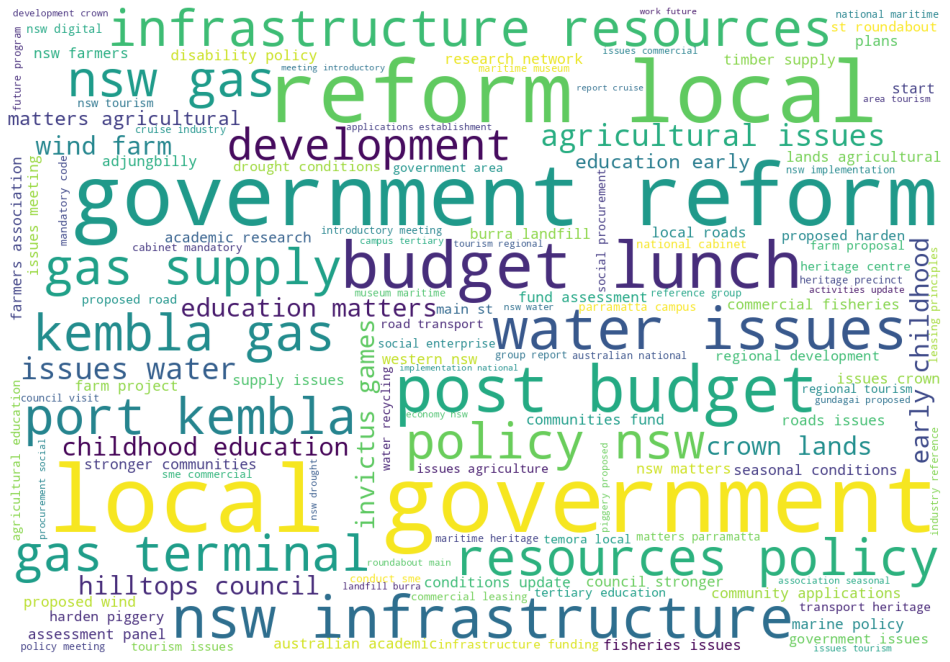

In [40]:
lobbyist_meeting_purpose = mining_company_associations.merge(diaries_df, left_on='ministerial_diary_id', right_on='id')[['lobbyist_org_name', 'purpose_of_meeting']]
mining_company_associations = mining_company_associations[mining_company_associations['lobbyist_org_name'].str.startswith('Barton ')]
comment_words = ''
stopwords = set(STOPWORDS)
for val in lobbyist_meeting_purpose['purpose_of_meeting'].str.lower():
    val = str(val)
    
    tokens = val.split(' ')
    out_tokens = []
    for i in range(len(tokens)):
            if tokens[i] not in ('discuss', 'discussion', 'hosted', 'status', 'deakin', 'barton'):
                out_tokens.append(tokens[i])
    comment_words += " ".join(out_tokens)+" "

wordcloud = WordCloud(width = 1300, height = 900,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (13, 9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [56]:
tmp = lobbyist_meeting_purpose.copy()
tmp['purpose_of_meeting_lower'] = tmp['purpose_of_meeting'].str.lower()
tmp[tmp['purpose_of_meeting_lower'].str.contains('kembla')].groupby(['lobbyist_org_name','purpose_of_meeting']).count()

,,purpose_of_meeting_lower
lobbyist_org_name,purpose_of_meeting,
Barton Deakin Pty Limited,To discuss the status of Port Kembla gas terminal,500


<AxesSubplot:xlabel='lobbyist_org_name'>

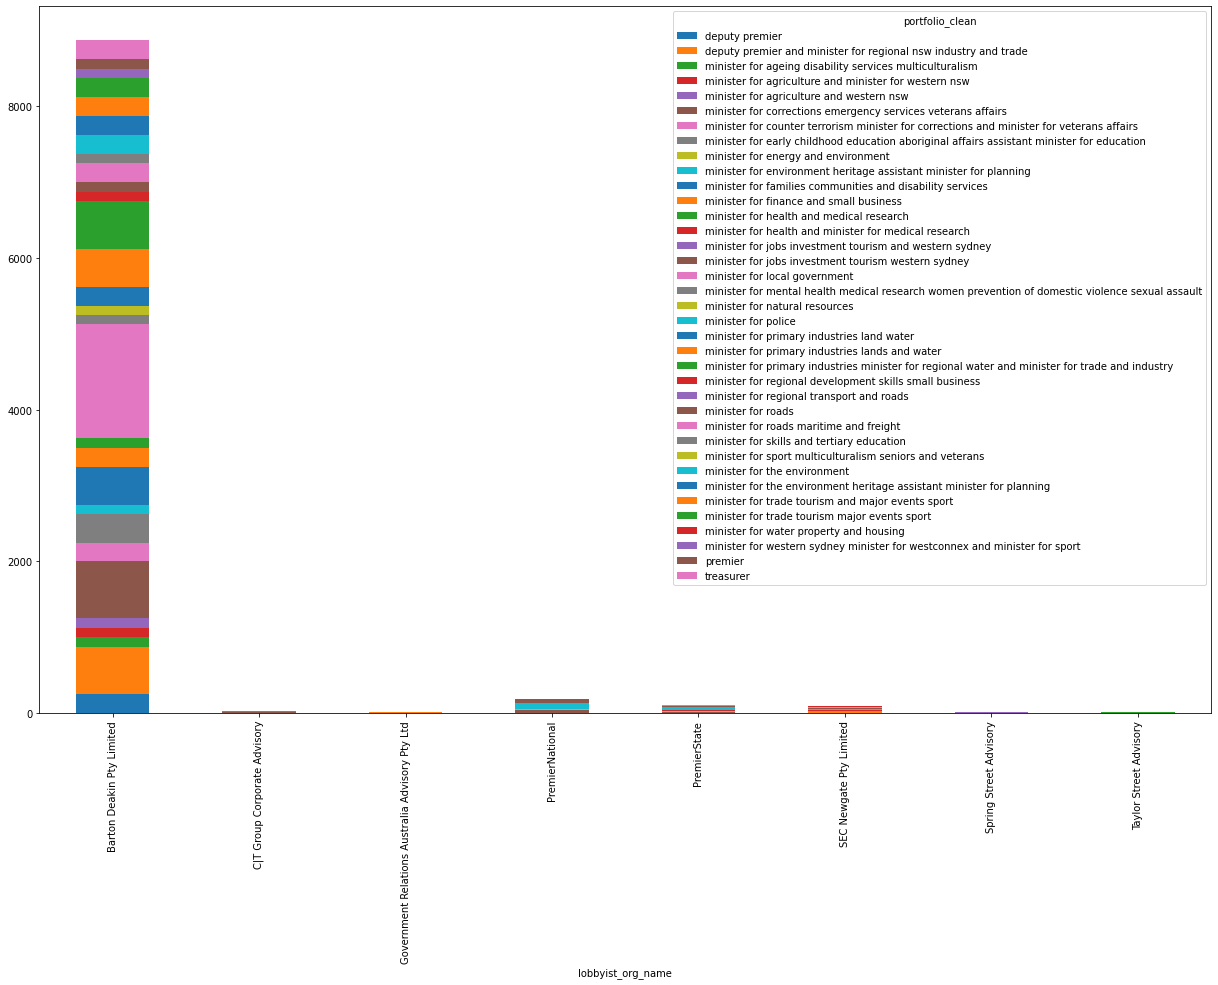

In [133]:
pd.pivot_table(ma_df, columns=['portfolio_clean'], values='weight', index='lobbyist_org_name').plot.bar(stacked=True)

## Donations Data

In [60]:
# move this to the loading logic
# donations_data['year'] = pd.to_numeric(donations_data['year'].fillna(-1), downcast = 'integer').astype(int)
print(f"{donations_data[donations_data['year'] != -1]['year'].min()} - {donations_data[donations_data['year'] != 2051]['year'].max()}")

2003 - 2019


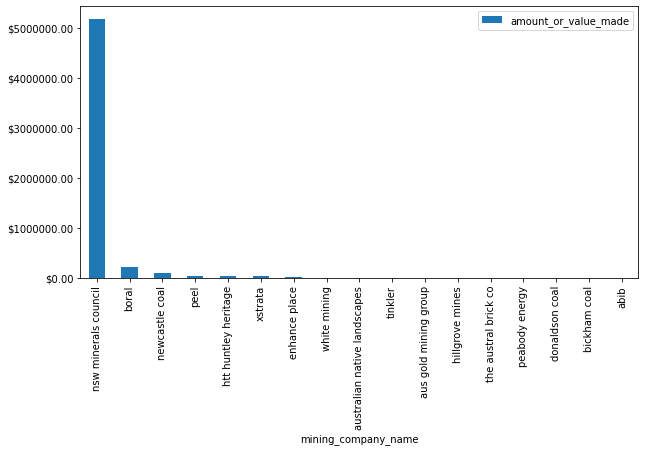

In [67]:
plt.rcParams["figure.figsize"] = (10,5)
mining_doner_associations = []
def _name_contains_mining_company(value):
    names = search.get_mining_company_names_clean()
    found = [n for n in names if n in value]
    [mining_doner_associations.append({ 'mining_company_name': name, 'doner_name': value}) 
            for name in found]
    return len(found) > 0
name_contains_mining_company = np.vectorize(_name_contains_mining_company)

donations_data['mining_company_found'] = name_contains_mining_company(donations_data["doner_name_switched"])
mining_donations_df = donations_data[donations_data['mining_company_found']]

mining_donations_df = pd.DataFrame(mining_doner_associations).merge(mining_donations_df, left_on = 'doner_name', right_on='doner_name_switched')

ax = mining_donations_df[['mining_company_name','amount_or_value_made']].groupby(['mining_company_name']).sum().sort_values('amount_or_value_made', ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

In [35]:
!pip install squarify

<AxesSubplot:>

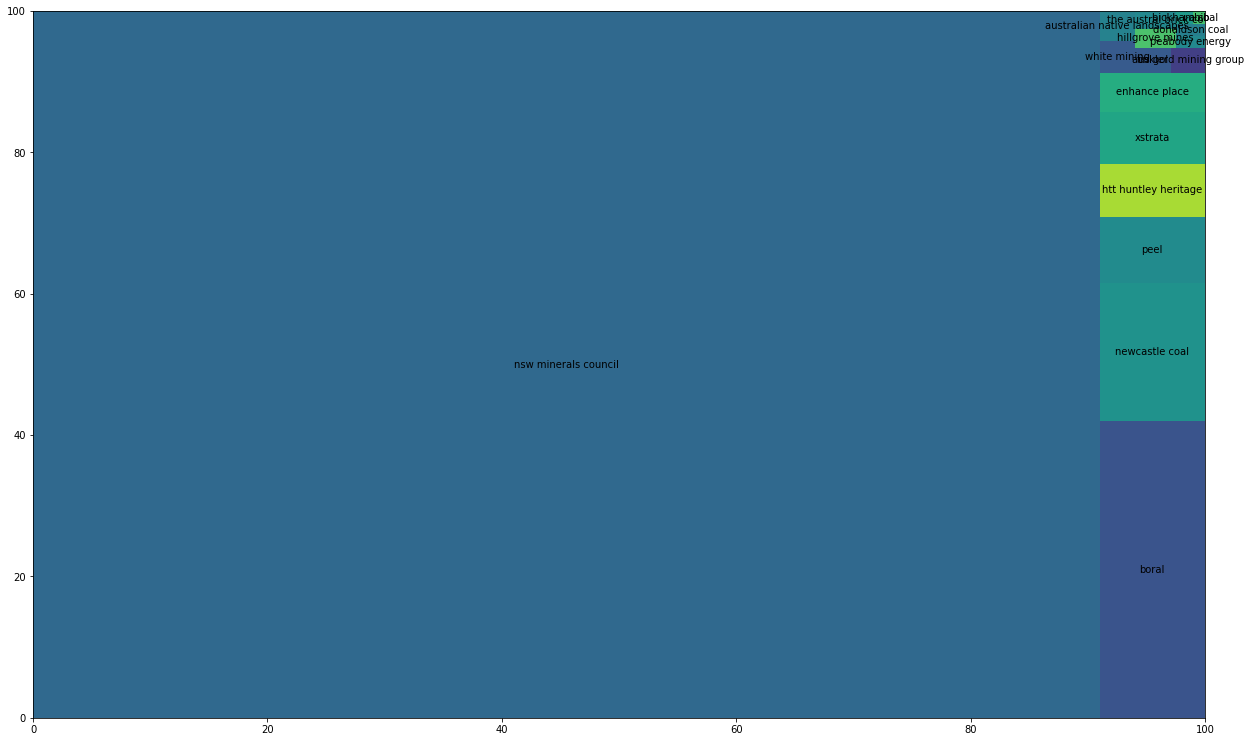

In [68]:
import squarify
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (21,13)
mining_donation_totals = mining_donations_df[['mining_company_name','amount_or_value_made']].groupby(['mining_company_name']).sum().reset_index().sort_values('amount_or_value_made', ascending=False)

squarify.plot(mining_donation_totals['amount_or_value_made'].astype(int), label=mining_donation_totals['mining_company_name'])

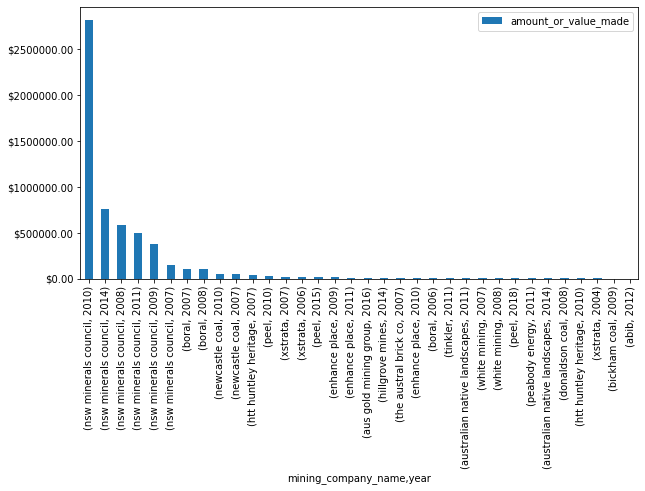

In [76]:
plt.rcParams["figure.figsize"] = (10,5)
ax = mining_donations_df[['year', 'mining_company_name','amount_or_value_made']].groupby(['mining_company_name','year']).sum().sort_values('amount_or_value_made', ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

In [101]:
mining_donations_df[mining_donations_df['mining_company_name'].str.startswith('nsw min') &(mining_donations_df['year'].str.contains('2010', na=False))][['year', 'mining_company_name','amount_or_value_made']]

,year,mining_company_name,amount_or_value_made
139,2010,nsw minerals council,1000.0
140,2010,nsw minerals council,500.0
141,2010,nsw minerals council,990.0
142,2010,nsw minerals council,6000.0
143,2010,nsw minerals council,6600.0
...,...,...,...
2605,2010,nsw minerals council,8000.0
2606,2010,nsw minerals council,500.0
2607,2010,nsw minerals council,750.0
2608,2010,nsw minerals council,750.0


Some Articles on NSW Minerals Council:
 - https://lobbymap.org/influencer/NSW-Mining-a8d4d226496cbdf13430b4d9338698d4
 - https://treasury.gov.au/sites/default/files/2019-03/NSW-Minerals-Council.pdf
 - https://www.epa.nsw.gov.au/-/media/epa/corporate-site/resources/licensing/hrsts/nsw-minerals-council.pdf

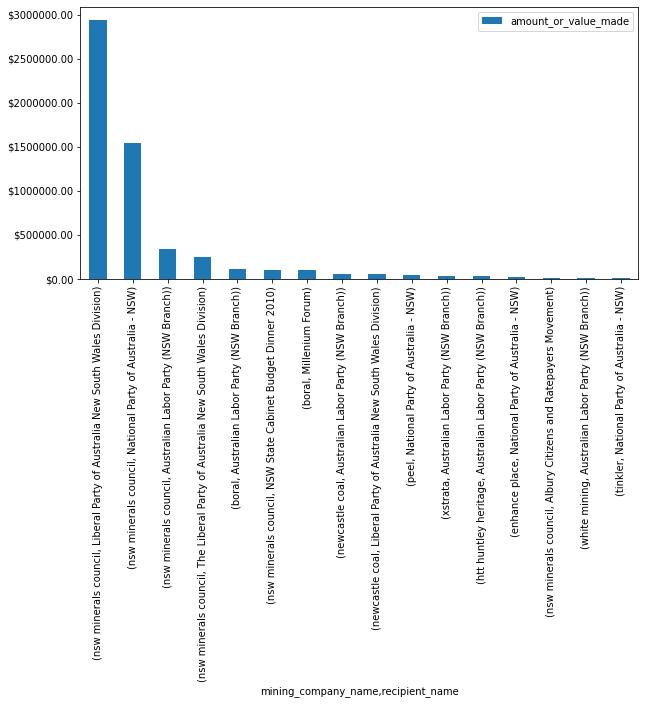

In [79]:
# ax = mining_donations_df[['recipient_name', 'mining_company_name','amount_or_value_made']].groupby(['mining_company_name','recipient_name']).sum().sort_values('amount_or_value_made', ascending=False).plot.bar()
# ax.yaxis.set_major_formatter('${x:1.2f}')
# mining_donations_df
plt.rcParams["figure.figsize"] = (10,5)

recipiants = mining_donations_df[['recipient_name', 'mining_company_name','amount_or_value_made']] \
    .groupby(['mining_company_name','recipient_name']) \
    .sum().sort_values('amount_or_value_made', ascending=False)
ax = recipiants[recipiants['amount_or_value_made'] > 6000].plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')


In [108]:
recipiants = recipiants.reset_index()[['recipient_name', 'amount_or_value_made']].groupby('recipient_name').sum()
total = recipiants['amount_or_value_made'].sum()
recipiants['percentage'] = (recipiants['amount_or_value_made'] / total) 
recipiants.sort_values('percentage', ascending=False)

,amount_or_value_made,percentage
recipient_name,,
Liberal Party of Australia New South Wales Division,2999370.0,0.527522
National Party of Australia - NSW,1623600.0,0.285555
Australian Labor Party (NSW Branch),581700.0,0.102308
The Liberal Party of Australia New South Wales Division,263688.0,0.046377
NSW State Cabinet Budget Dinner 2010,100000.0,0.017588
Millenium Forum,96250.0,0.016928
Albury Citizens and Ratepayers Movement,11000.0,0.001935
"Stokes, Robert",5000.0,0.000879
Progressive Business (VIC),3162.5,0.000556


Lets see if any lobbyist organisations are making donations

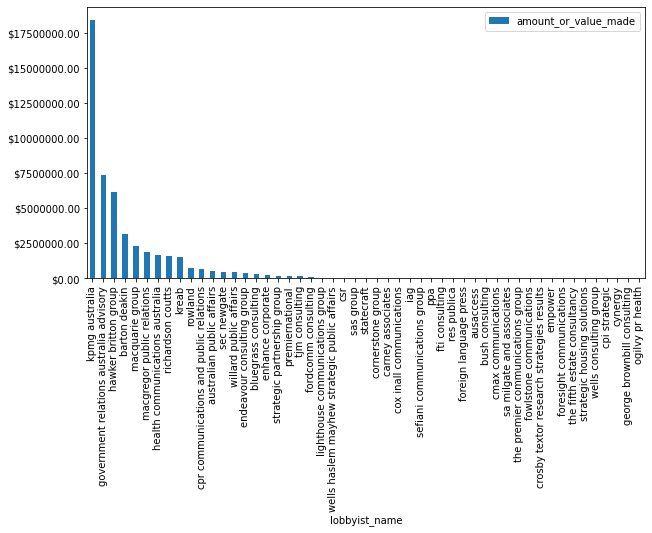

In [110]:
lobbyist_doner_associations = []
def _name_contains_lobbyist_org(value):
    names = unique_lobbyist_orgs_df['lobbyist_org_name_clean']
    found = [n for n in names if n in value]
    [lobbyist_doner_associations.append({ 'lobbyist_name': name, 'doner_name': value}) 
            for name in found]
    return len(found) > 0
name_contains_lobbyist_org = np.vectorize(_name_contains_lobbyist_org)


donations_data['lobbyist_org_found'] = name_contains_lobbyist_org(donations_data["doner_name_switched"])
mining_donations_df = donations_data[donations_data['lobbyist_org_found']]

lobbyist_donations_df = pd.DataFrame(lobbyist_doner_associations).merge(mining_donations_df, left_on = 'doner_name', right_on='doner_name_switched')

ax = lobbyist_donations_df[lobbyist_donations_df['lobbyist_name'] != 'currie'][['lobbyist_name','amount_or_value_made']].groupby(['lobbyist_name']).sum().sort_values('amount_or_value_made', ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

So we can see here that Barton Deakin is in the top five in total donations, this is also a

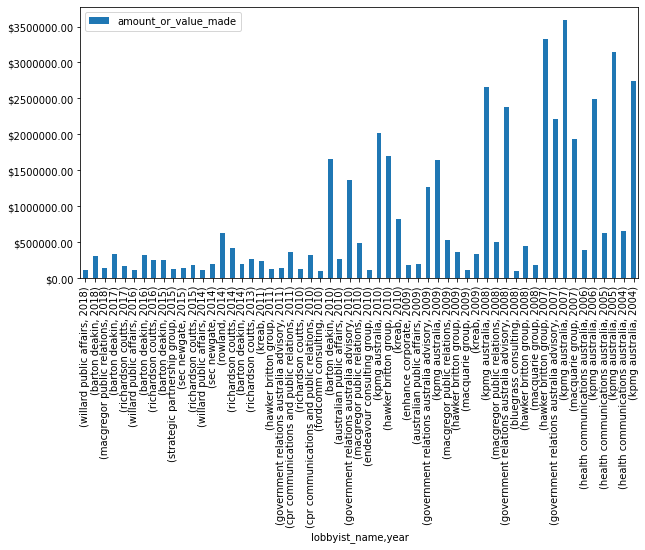

In [124]:
year_by_year = lobbyist_donations_df[lobbyist_donations_df['lobbyist_name'] != 'currie'][['year', 'lobbyist_name','amount_or_value_made']] \
    .groupby(['lobbyist_name','year']) \
    .sum().sort_values('year', ascending=False)

year_by_year[year_by_year['amount_or_value_made'] > 6000]

ax = year_by_year[year_by_year['amount_or_value_made'] > 100000].plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

It seems like 2010 was a big year for donations

In [66]:
unique_lobbyist_orgs_df[unique_lobbyist_orgs_df['lobbyist_org_name_clean'] == 'currie']

,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
479,82050913909.0,Currie,82050913909,currie


In [70]:
unique_employees[unique_employees['lobbyist_abn_clean'] == 82050913909]

,lobbyist_name_clean,lobbyist_abn_clean,federal,nsw,qld,sa,count
1124,mark paterson,82050913909,1,0,0,0,1
1659,susan mcnair,82050913909,1,0,0,0,1


In [67]:
lobbyist_donations_df[lobbyist_donations_df['lobbyist_name'] == 'currie']


,lobbyist_name,doner_name,recipient_name,type,amount_or_value_made,clean_donor_name,doner_name_switched,date_donation_made,year,mining_company_found,lobbyist_org_found
2981,currie,c currie,Liberal Party of Australia New South Wales Div...,Party,1000.0,"currie, c",c currie,19/8/2009,2009,False,True
2982,currie,carolyn currie,Tony Abbott,Recipient,300.0,"currie, carolyn",carolyn currie,16/2/2010,2010,False,True
2983,currie,carolyn currie,Tony Abbott,Recipient,375.0,"currie, carolyn",carolyn currie,15/2/2010,2010,False,True
2984,currie,carolyn currie,Tony Abbott,Recipient,1500.0,"currie, carolyn",carolyn currie,18/2/2010,2010,False,True
2985,currie,carolyn currie,Tony Abbott,Recipient,250.0,"currie, carolyn",carolyn currie,2/3/2010,2010,False,True
...,...,...,...,...,...,...,...,...,...,...,...
8753,currie,carolyn currie,The Liberal Party of Australia New South Wales...,Party,85.0,"currie, carolyn",carolyn currie,7/3/2018,2018,False,True
8754,currie,carolyn currie,The Liberal Party of Australia New South Wales...,Party,50.0,"currie, carolyn",carolyn currie,8/3/2018,2018,False,True
8755,currie,carolyn currie,The Liberal Party of Australia New South Wales...,Party,50.0,"currie, carolyn",carolyn currie,14/3/2018,2018,False,True
8756,currie,carolyn currie,The Liberal Party of Australia New South Wales...,Party,60.0,"currie, carolyn",carolyn currie,24/4/2018,2018,False,True


The link with Currie lobbyist organisation is not correct, these donations appear to be coming from Carolyn Currie, a prominant Liberal party member.

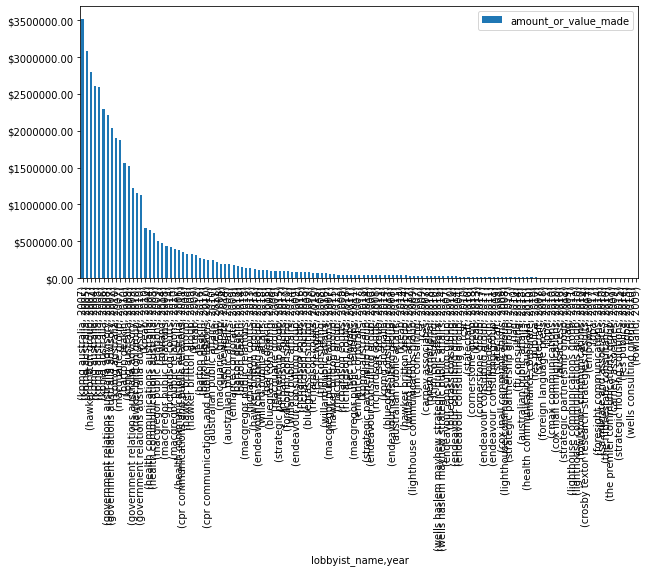

In [109]:
ax = lobbyist_donations_df[(lobbyist_donations_df['amount_or_value_made'] > 1000) & (lobbyist_donations_df['lobbyist_name'] != 'currie')][['year', 'lobbyist_name','amount_or_value_made']].groupby(['lobbyist_name','year']).sum().sort_values('amount_or_value_made', ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

### Barton Deakin

So we know that the Barton Deakin lobbyist organisation has a lot of ties to mining companies, as well as a lot of interactions with ministers which is evident from the analysis on the ministerial diaries, lets take a look at thier donations. And based on the plot below it looks like they are donating to the Liberal party and Nationals exclusively.

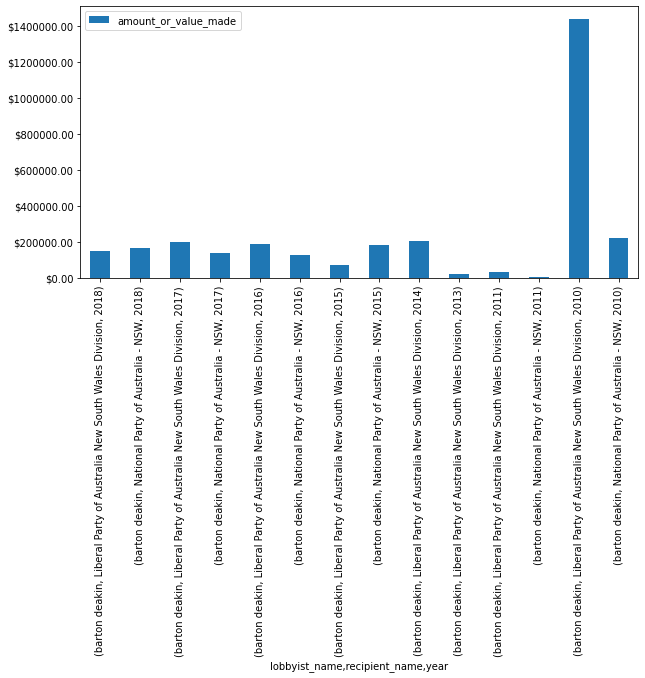

In [125]:
barton_deakin_donations_df = lobbyist_donations_df[lobbyist_donations_df['lobbyist_name'] == 'barton deakin']
barton_deakin_donations_df.loc[barton_deakin_donations_df['recipient_name'].str.startswith('The Liberal'), 'recipient_name'] = "Liberal Party of Australia New South Wales Division"
ax = barton_deakin_donations_df[['year', 'lobbyist_name','amount_or_value_made','recipient_name']] \
    .groupby(['lobbyist_name','recipient_name','year']).sum() \
    .sort_values(['year'], ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')


Barton Deakin key memebers (https://bartondeakin.com/our-people/):

 - **Grahame Morris** former federal director of Bartion Deakin, served as Deputy Federal Director of the Liberal Party and State Director of the SA Liberal Party. He also had a distinguished career at Parliament House serving as parliamentary adviser to Liberal Leaders Andrew Peacock and Alexander Downer and as Chief of Staff to former Prime Minister, John Howard.
 - **Anthony Benscher** Anthony is Managing Director of Barton Deakin’s NSW division, former chief of Staff to the Minister for Family and Community Services in O’Farrell Government (Liberal party), former senior policy and communications adviser to John Howard for seven years.



In [119]:
all_lobbyist_employees_df[all_lobbyist_employees_df['lobbyist_name_clean'] == 'anthony benscher']
# all_lobbyist_employees_df.columns

,lobbyist_abn,lobbyist_name,title,lobbyist_name_clean,lobbyist_abn_clean
1313,65140067287.0,Anthony Benscher,Managing Director (NSW),anthony benscher,65140067287


In [121]:
unique_lobbyist_orgs_df[unique_lobbyist_orgs_df['abn_clean'] == 65140067287]

,abn,lobbyist_org_name,abn_clean,lobbyist_org_name_clean
371,65140067287.0,Barton Deakin Pty Limited,65140067287,barton deakin


### KPMG

KPMG is by far the most generaus when it comes to making donations, so lets take a look at how they spend their money.

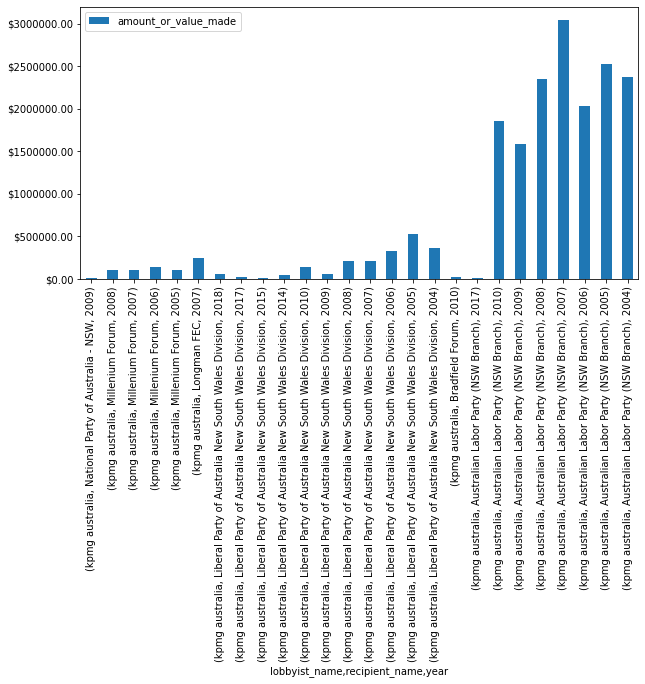

In [123]:
kpmg_donations_df = lobbyist_donations_df[lobbyist_donations_df['lobbyist_name'] == 'kpmg australia']
kpmg_donations_df.loc[kpmg_donations_df['recipient_name'].str.startswith('The Liberal'), 'recipient_name'] = "Liberal Party of Australia New South Wales Division"
ax = kpmg_donations_df[['year', 'lobbyist_name','amount_or_value_made','recipient_name']] \
    .groupby(['lobbyist_name','recipient_name','year']).sum() \
    .sort_values(['recipient_name', 'year'], ascending=False).plot.bar()
ax.yaxis.set_major_formatter('${x:1.2f}')

# squarify.plot(mining_donation_totals['amount_or_value_made'].astype(int), label=mining_donation_totals['mining_company_name'])

## Linking Lobbyists to Ministerial Diaries

In [60]:
query = """
select name, job_title, trading_name, legal_name, jurisdiction 
from (
	select lfe.lobbyists_name name, lfe.job_title, lf.trading_name, lf.legal_name, 'Federal' jurisdiction 
	from lobbyist_federal_employee lfe 
		inner join lobbyist_federal lf 
			on lf.abn  = lfe.organisations_abn 
			and lf.abn is not null
			and lfe.organisations_abn is not null
	union
	select lne.name, lne.postion, ln2.trading_name, ln2.name, 'NSW'   
	from lobbyist_nsw_employee lne 
		inner join lobbyist_nsw ln2 
			on ln2.id = lne.lobbyist_nsw_id 
	union
	select lqe.name, lqe.position, lq.trading_name, lq.name, 'QLD'   
	from lobbyist_qld_employee lqe 
		inner join lobbyist_qld lq 
			on lqe.lobbyist_qld_id = lq.id 
	union
	select lse.employee_name, lse.employee_position, ls.trading_name, ls.business_name, 'SA'    
	from lobbyist_sa_employee lse 
		inner join lobbyist_sa ls 
			on ls.abn  = lse.lobbyist_abn 
			and ls.abn is not null
			and lse.lobbyist_abn is not null
) e
group by name, job_title, trading_name, legal_name, jurisdiction 
"""

def _clean_employee_name(name):
    name = name.lower()
    name = name.replace('  ', ' ').strip()
	
    return name
clean_employee_name = np.vectorize(_clean_employee_name)

all_employees_df = pd.read_sql_query(query, cnx)
all_employees_df["name_cleaned"] = clean_employee_name(all_employees_df["name"])
all_employees_df["name_cleaned"] = all_employees_df['name_cleaned'].str.replace(r'[^\w\s]+', '')
employee_names = all_employees_df["name_cleaned"].unique()
employee_names

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.


array(['aaron parnell', 'adam howard', 'adam facer', ..., 'ian dalgliesh',
       'kate pembroke', 'the hon robert borbidge ao'], dtype=object)

In [87]:
query = """
select * from ministerial_diary md 
"""
ministerial_diary_df = pd.read_sql(query, cnx)
ministerial_diary_df

import regex as re

employee_associations = []
def _link_to_lobbyist_employee_name(org_ind, id, use_regex = False):
    
    evalute = lambda n : n in org_ind
    if use_regex:
        evalute = lambda n : re.match('[\s|^]' + n + '[\s|$]', org_ind)

    found = [en for en in employee_names if evalute(en)]
    [employee_associations.append({ 'ministerial_diary_id': id, 'lobbyist_employee_name': name, 'organisation_individual': org_ind}) for name in found]
    return len(found) > 0

link_to_lobbyist_employee_name = np.vectorize(_link_to_lobbyist_employee_name)
ministerial_diary_df["organisation_individual"] = ministerial_diary_df["organisation_individual"].str.replace(r'[^\w\s]+', '')
ministerial_diary_df["organisation_individual"] = ministerial_diary_df["organisation_individual"].str.lower()

ministerial_diary_df["link"] = link_to_lobbyist_employee_name(ministerial_diary_df["organisation_individual"], ministerial_diary_df["id"])
ministerial_diary_df[ministerial_diary_df["link"] == True]

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


,id,date,portfolio,organisation_individual,purpose_of_meeting,jurisdiction,import_file_name,link
240,241,17/06/2021,Minister for Sport Multiculturalism Seniors an...,brian tyson managing partner newgate,Introductory meeting \nDisclosure Summary,NSW,Minister-for-Sport-Multiculturalism-Seniors-an...,True
601,602,7/11/2014,Minister for Local Government Disclosure Summa...,minister katrina hodgkinson,Local government reform,NSW,Minister-for-Local-Government-Disclosure-Summa...,True
912,913,15/10/2021,Minister for Finance and Small Business 1 21,tim robertson advisory,"Commercial and Retail Leasing Regulation, COVI...",NSW,Minister-for-Finance-and-Small-Business-1-Octo...,True
1049,1050,7/11/2016,Minister for Roads Maritime and Freight Disclo...,michael johnson mp,Singleton Bypass,NSW,Minister-for-Roads-Maritime-and-Freight-Disclo...,True
1109,1110,07/07/2020,Minister for Sport Multiculturalism Seniors an...,brian tyson managing partner newgate,Sport matters,NSW,Minister-for-Sport-Multiculturalism-Seniors-an...,True
...,...,...,...,...,...,...,...,...
110412,110413,24 March 2021,mark ryan,dave whimpey karly abbott,Parliamentary Friends of Surf \nLife Saving Event,QLD_pdfs,mark-ryan_march2021.pdf,True
111457,111458,8 June 2021,shannon fentiman,alistair nicholas consulting,Meeting,QLD_pdfs,shannon-fentiman_june2021.pdf,True
111827,111828,28 June 2021,cameron dick,rachel drew holding redlich david quinn holding,Ministerial \nPortfolio Matters,QLD_pdfs,cameron-dick_june2021.pdf,True
111834,111835,28 June 2021,cameron dick,unitywater re partners david nelson director,Ministerial \nPortfolio Matters,QLD_pdfs,cameron-dick_june2021.pdf,True


In [129]:
employee_associations_staging = []
evaluate = lambda n, o : len(re.findall(r'\b' + n + r'\b', o)) > 0
for a in employee_associations:
    a['match'] = evaluate(a['lobbyist_employee_name'], a['organisation_individual'])


employee_associations_df = pd.DataFrame(employee_associations)
employee_associations_df[employee_associations_df['match'] == True]

,ministerial_diary_id,lobbyist_employee_name,organisation_individual,match
0,241,brian tyson,brian tyson managing partner newgate,True
1,602,katrina hodgkinson,minister katrina hodgkinson,True
2,913,tim robertson,tim robertson advisory,True
3,1050,michael johnson,michael johnson mp,True
4,1110,brian tyson,brian tyson managing partner newgate,True
...,...,...,...,...
307,110413,karly abbott,dave whimpey karly abbott,True
308,111458,alistair nicholas,alistair nicholas consulting,True
309,111828,david quinn,rachel drew holding redlich david quinn holding,True
310,111835,david nelson,unitywater re partners david nelson director,True


In [125]:
name = 'brian tyson'
text = 'brian tyson managing partner newgate'
pattern = r'\b' + name + r'\b'
re.findall(pattern, text)

['brian tyson']

OK so not getting any matches on the first name last name of the lobbyist employees, so we will try searching for the owners and the name of the lobbyist company itself, see if we get any hits that way

In [79]:
query = """
select lqo.name, lq.name business_name, lq.trading_name , 'QLD' jurisdiction
from lobbyist_qld_owner lqo 
	inner join lobbyist_qld lq 
		on lqo.lobbyist_qld_id  = lq.id 
union
select lno.name, ln2.name, ln2.trading_name, 'NSW' jurisdiction 
from lobbyist_nsw_owner lno 
	inner join lobbyist_nsw ln2 
		on lno.lobbyist_nsw_id = ln2.id 
"""



all_owners_df = pd.read_sql(query, cnx)
all_owners_df['name_cleaned'] = clean_employee_name(all_owners_df['name'])
all_owners_df['name_cleaned'] = all_owners_df['name_cleaned'].str.replace(r'[^\w\s]+', '')

owner_names = all_owners_df['name_cleaned'].unique()
owner_associations = []

def _link_to_lobbyist_owner_name(org_ind, id):
	found = [o for o in owner_names if o in org_ind]
	[owner_associations.append({ 'ministerial_diary_id': id, 'lobbyist_owner_name': name, 'organisation_individual': org_ind }) for name in found]
	return len(found) > 0


link_to_lobbyist_owner_name = np.vectorize(_link_to_lobbyist_owner_name)

ministerial_diary_df["owner_link"] = link_to_lobbyist_owner_name(ministerial_diary_df["organisation_individual"], ministerial_diary_df["id"])
ministerial_diary_df[ministerial_diary_df["owner_link"] == True]

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


,id,date,portfolio,organisation_individual,purpose_of_meeting,jurisdiction,import_file_name,link,owner_link
423,424,21/03/2017,Minister for Roads Maritime and Freight Disclo...,fulton and hogan construction proprietary limi...,Berry bypass and Princess Highway projects,NSW,Minister-for-Roads-Maritime-and-Freight-Disclo...,False,True
912,913,15/10/2021,Minister for Finance and Small Business 1 21,tim robertson advisory,"Commercial and Retail Leasing Regulation, COVI...",NSW,Minister-for-Finance-and-Small-Business-1-Octo...,True,True
1527,1528,08/02/2021,Minister for Skills and Tertiary Education,stephen cartwright,TAFE matters,NSW,Minister-for-Skills-and-Tertiary-Education-Jan...,True,True
1938,1939,25/05/2015,Minister for Planning Disclosure Summary,morris iemma,Social Housing policy forum,NSW,Minister-for-Planning-Disclosure-Summary-April...,True,True
2061,2062,10/11/2015,Minister for Mental Health Medical Research Wo...,womens domestic violence court advocacy servic...,"WDVCAS funding, Safer Pathways and the Domesti...",NSW,Minister-for-Mental-Health-Medical-Research-Wo...,False,True
...,...,...,...,...,...,...,...,...,...
112832,112833,8 March 2022,shannon fentiman,bernie hogan ceo queensland hotels,Queensland Hotels \nAssociation Hotels \nSympo...,QLD_pdfs,shannon-fentiman_march2022.pdf,False,True
114880,114881,22 March 2022,cameron dick,clubs queensland invited guests with departmen...,Awards for \nExcellence gala \ndinner,QLD_pdfs,cameron-dick_march2022.pdf,False,True
115082,115083,18 February 2021,dianne farmer,bernie hogan chief executive,Video Meeting,QLD_pdfs,dianne-farmer_february2021.pdf,False,True
116410,116411,22 September 2021,mick de brenni,ian mackay steve burgess and,Meeting,QLD_pdfs,mick-de-brenni_september2021.pdf,False,True


In [81]:
pd.DataFrame(owner_associations)

,ministerial_diary_id,lobbyist_owner_name,organisation_individual
0,424,hogan c,fulton and hogan construction proprietary limi...
1,913,tim robertson,tim robertson advisory
2,1528,stephen cartwright,stephen cartwright
3,1939,morris iemma,morris iemma
4,2062,court a,womens domestic violence court advocacy servic...
...,...,...,...
207,112833,hogan c,bernie hogan ceo queensland hotels
208,114881,clubs queensland,clubs queensland invited guests with departmen...
209,115083,hogan c,bernie hogan chief executive
210,116411,kay st,ian mackay steve burgess and


No links to the owners either

## Identifying Mining companies in the client lists

In [8]:

query = """
select 
	lfc.clients_name client_name
	, lfc.organisations_abn lobbyist_abn
	, lf.trading_name lobbyist_trading_name 
	, 'Federal' jurisdiction
from lobbyist_federal_client lfc
	inner join lobbyist_federal lf 
		on lf.abn = lfc.organisations_abn 
		and lf.abn is not null
union
select 
	lnc.name
	, ln2.abn
	, ln2.trading_name 
	, 'NSW' jurisdiction  
from lobbyist_nsw_client lnc 
	inner join lobbyist_nsw ln2 
		on lnc.lobbyist_nsw_id = ln2.id
union
select 
	lqc.name
	, lq.abn
	, lq.trading_name 
	, 'QLD' jurisdiction  
from lobbyist_qld_client lqc 
 	inner join lobbyist_qld lq 
 		on lqc.lobbyist_qld_id = lq.id 
 union
 select 
 	lsc.client_name
 	, lsc.lobbyist_abn
 	, ls.trading_name
 	, 'SA' jurisdiction  
 from lobbyist_sa_client lsc
 	inner join lobbyist_sa ls 
 		on ls.abn = lsc.lobbyist_abn 
"""


all_clients_df = pd.read_sql_query(query, cnx)
# all_clients_df = all_clients_df[all_clients_df['lobbyist_abn'].isna() == False]
all_clients_df['client_name'] = all_clients_df['client_name'].str.replace('\t', '')
all_clients_df['lobbyist_abn'] = all_clients_df['lobbyist_abn'].astype(str)
all_clients_df['lobbyist_abn'] = all_clients_df['lobbyist_abn'].str.replace('ABN', '')
all_clients_df['lobbyist_abn'] = all_clients_df['lobbyist_abn'].str.replace('ACN', '')
all_clients_df['lobbyist_abn'] = all_clients_df['lobbyist_abn'].str.split(',').str[0]
all_clients_df['lobbyist_abn'] = all_clients_df['lobbyist_abn'].str.split('.').str[0]
all_clients_df['lobbyist_abn'] = pd.to_numeric(all_clients_df['lobbyist_abn']).astype('Int64')


I have manually built up a list of mining companies from a couple of websites that came up in a google search for mining companies operating in Australia, which came up with the following links, this is not an exhaustive list however it is somewhere to start:

 - http://iminco.net/queensland-mining-companies/
 - http://iminco.net/mining-companies-australia/

In [11]:
mining_data_df = pd.read_csv('../NSW_Mining_data.csv')
# http://iminco.net/queensland-mining-companies/
mining_companies = [
    'Adani Mining',
    'Anglo Coal',
    'BHP Billiton',
    'Caledon Coal',
    'Carabella Resources',
    'Citigold',
    'Ensham Resources',
    'Ernest Henry Mining',
    'Jellinbah Group',
    'New Hope Coal',
    'Newlands Coal',
    'Oaky Creek Coal',
    'Opal Horizon',
    'Peabody Energy',
    'Perilya Mines',
    'Qcoal',
    'Rio Tinto',
    'Yancoal',

    # http://iminco.net/mining-companies-australia/

    'Bechtel',
    'Cuesta Coal',
    'Fortescue Metals',
    'GLOUCESTER COAL',
    'GVK Industries',
    'Hancock Prospecting',
    'Tinkler',
    'Newmont Corporation',
    'OZ MINERALS' ,
    'Xstrata',
    'NSW Minerals Council'
]
# this works but will need to be more efficent
mining_companies_df = mining_data_df[['company', 'title_no']].groupby('company').mean().reset_index()
remove_words = ['pty', 'ltd', 'proprietary', 'limited', 'company', '.', 'no1']

mining_companies_df['company_cleaned'] = mining_companies_df['company'].str.lower()
for word in remove_words:
    mining_companies_df['company_cleaned'] = mining_companies_df['company_cleaned'].str.replace(word, '')
mining_companies_df['company_cleaned'] = mining_companies_df['company_cleaned'].str.strip()
[mining_companies.append(c) for c in mining_companies_df['company_cleaned']] 

associations_found = []
def _is_mining_company(client_name):
    found = [name for name in mining_companies if name.lower() in client_name.lower()]
    if len(found) > 0:
        associations_found.append({ "name": client_name, "found": found})
    return len(found) > 0

is_mining_company = np.vectorize(_is_mining_company)
mining_lobbyists_df = all_clients_df[is_mining_company(all_clients_df['client_name'])]
mining_lobbyists_df

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,client_name,lobbyist_abn,lobbyist_trading_name,jurisdiction
1032,BECHTEL AUSTRALIA PROPRIETARY LIMITED,38162366056,SEC Newgate Pty Limited,NSW
1049,BENGALLA MINING COMPANY PTY LIMITED,20126507211,Richardson Coutts Pty Ltd,NSW
1059,BHP Billiton Group,50082123822,GRACosway Pty Ltd,Federal
1060,BHP Billiton Iron Ore Pty Ltd,56131702755,GRA Partners Pty Ltd,Federal
1061,BHP Billiton Ltd,50056165827,John Connolly & Partners,NSW
1134,BORAL CEMENT LIMITED,65140067287,Barton Deakin Pty Limited,NSW
1135,BORAL LIMITED,51069838222,The Fifth Estate,NSW
1136,BORAL RECYCLING PTY LIMITED,92715851492,Chikarovski & Associates Pty Ltd,NSW
1137,BORAL RESOURCES (QLD) PTY. LIMITED,51069838222,The Fifth Estate,NSW
1279,Bengalla Mining Company,20126507211,Richardson Coutts,Federal


In [12]:
associations_found

[{'name': 'BECHTEL AUSTRALIA PROPRIETARY LIMITED', 'found': ['Bechtel']},
 {'name': 'BENGALLA MINING COMPANY PTY LIMITED', 'found': ['bengalla mining']},
 {'name': 'BHP Billiton Group ', 'found': ['BHP Billiton']},
 {'name': 'BHP Billiton Iron Ore Pty Ltd ', 'found': ['BHP Billiton']},
 {'name': 'BHP Billiton Ltd', 'found': ['BHP Billiton']},
 {'name': 'BORAL CEMENT LIMITED', 'found': ['boral cement', 'boral']},
 {'name': 'BORAL LIMITED', 'found': ['boral']},
 {'name': 'BORAL RECYCLING PTY LIMITED', 'found': ['boral']},
 {'name': 'BORAL RESOURCES (QLD) PTY. LIMITED', 'found': ['boral']},
 {'name': 'Bengalla Mining Company', 'found': ['bengalla mining']},
 {'name': 'Bickham Coal', 'found': ['bickham coal']},
 {'name': 'CSR BUILDING PRODUCTS LIMITED', 'found': ['csr building products']},
 {'name': 'Cobalt Blue Holdings Ltd', 'found': ['cobalt blue holdings']},
 {'name': 'FORTESCUE METALS GROUP LTD', 'found': ['Fortescue Metals']},
 {'name': 'Fortescue Metals Group', 'found': ['Fortescue 

## Identifyin mining companies in the political donations data

In [43]:
associations_found = []
political_donations_df = pd.read_csv("../NSW_Donations.csv")
remove_words = ['pty', 'ltd', 'proprietary', 'limited', 'company', '.', 'no1']
political_donations_df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_') for c in political_donations_df.columns]
political_donations_df["clean_donor_name"] = political_donations_df["donor_name"]
for word in remove_words:
        political_donations_df["clean_donor_name"]  = political_donations_df["clean_donor_name"] .str.replace(word, '')

political_donations_df["amount_or_value_made"] = political_donations_df["amount_or_value_made"].str.extract('(\d*\.\d*|\d*,\d*\.\d*)', expand=False)
political_donations_df["amount_or_value_made"] = pd.to_numeric(political_donations_df["amount_or_value_made"].str.replace(',', ''))

political_donations_df = political_donations_df[~political_donations_df['date_donation_made'].str.startswith("Total Valid Amount", na=False)]

mining_donations_df = political_donations_df[is_mining_company(political_donations_df["clean_donor_name"])]
mining_donations_df.groupby(['donor_name', 'disclosure_period', 'recipient_name']).agg({ 'amount_or_value_made': np.sum }).sort_values('amount_or_value_made', ascending = False)


/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


amount_or_value_made
donor_name                                      disclosure_period      recipient_name                                                          
Newcastle Coal Infrastructure Group Pty Ltd     1/07/2010 - 30/06/2011 Liberal Party of Australia New South Wales Divi...               50000.0
Newcastle Coal Infrastructure Group Pty Limited 1/07/2008 - 31/12/2008 Australian Labor Party (NSW Branch)                              50000.0
Boral Limited                                   1/07/2008 - 31/12/2008 Australian Labor Party (NSW Branch)                              22000.0
                                                                       Millenium Forum                                                  19250.0
Xstrata Coal Pty Limited                        1/07/2008 - 31/12/2008 Australian Labor Party (NSW Branch)                              12550.0
HTT Huntley Heritage Pty Ltd                    1/07/2008 - 31/12/2008 Australian Labor Party (NSW Branch)                              12150.0
AUS GOLD MINING GROUP PTY LIMITED               1/07/2016 - 30/06/2017 The Liberal Party of Australia New South Wales ...                5888.0
Hillgrove Mines Pty Ltd                         1/07/2013 - 30/06/2014 The Liberal Party of Australia New South Wales ...                5500.0
Australian Native Landscapes Pty Ltd            1/07/2010 - 30/06/2011 Stokes, Robert                                                    5000.0
The Austral Brick Co P/L                        1/07/2008 - 31/12/2008 Liberal Party of Australia New South Wales Divi...                5000.0
Tinkler, Nathan                                 1/07/2010 - 30/06/2011 National Party of Australia - NSW                                 5000.0
Enhance Place Pty Ltd                           1/07/2009 - 31/12/2009 National Party of Australia - NSW                                 2610.0
Peabody Energy Australia Pty Ltd                1/07/2010 - 30/06/2011 National Party of Australia - NSW                                 2300.0
Donaldson Coal Pty Limited                      1/07/2008 - 31/12/2008 National Party of Australia - NSW                                 2250.0
HTT Huntley Heritage                            1/01/2010 - 30/06/2010 Hay, Noreen                                                       2000.0
Enhance Place Pty Ltd                           1/07/2010 - 30/06/2011 National Party of Australia - NSW                                 2000.0
Bickham Coal Company Pty Ltd                    1/07/2009 - 31/12/2009 National Party of Australia - NSW                                 1500.0
Tinkler Group Holdings Administration Pty Ltd   1/07/2009 - 31/12/2009 National Party of Australia - NSW                                 1250.0
AUSTRALIAN NATIVE LANDSCAPES                    1/07/2014 - 30/06/2015 The Liberal Party of Australia New South Wales ...                1150.0
Habib, Elizabeth                                1/07/2012 - 30/06/2013 Liberal Party of Australia New South Wales Divi...                1100.0
Enhance Place Pty Ltd                           1/07/2010 - 30/06/2011 Australian Labor Party (NSW Branch)                               1000.0
Boral Limited                                   1/07/2008 - 31/12/2008 Liberal Party of Australia New South Wales Divi...                1000.0
                                                                       Progressive Business (VIC)                                         632.5

Now one name appears in the above list which I was not expecting and initally thought was a mistake "Australian Native Landscapes Pty Ltd", but if we double check this against the mining leases data they are in there, looks like they are doing some mining on minirals, most likely for producing furtilisers I guess.

In [19]:
mining_data_df[mining_data_df["holder"].str.strip() == 'AUSTRALIAN NATIVE LANDSCAPES PTY LTD'][['holder', 'minerals']]


,holder,minerals
1550,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Agricultural Lime, Cobalt, Copper, Gold, Lead,..."
1618,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Cobalt, Copper, Gold, Lead, Limestone, Nickel,..."
1631,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Cobalt, Copper, Gold, Lead, Limestone, Marble,..."
1632,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Cobalt, Copper, Gold, Lead, Limestone, Marble,..."
1774,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Agricultural Lime, Cobalt, Copper, Gold, Lead,..."
2222,AUSTRALIAN NATIVE LANDSCAPES PTY LTD ...,"Copper, Gold, Lead, Nickel, Silver, Zinc"


In [14]:
associations_found

[{'name': 'AUS GOLD MINING GROUP PTY LIMITED',
  'found': ['aus gold mining group']},
 {'name': 'AUS GOLD MINING GROUP PTY LIMITED',
  'found': ['aus gold mining group']},
 {'name': 'AUSTRALIAN NATIVE LANDSCAPES',
  'found': ['australian native landscapes']},
 {'name': 'AUSTRALIAN NATIVE LANDSCAPES',
  'found': ['australian native landscapes']},
 {'name': 'AUSTRALIAN NATIVE LANDSCAPES',
  'found': ['australian native landscapes']},
 {'name': 'Australian Native Landscapes Pty Ltd',
  'found': ['australian native landscapes']},
 {'name': 'Australian Native Landscapes Pty Ltd',
  'found': ['australian native landscapes']},
 {'name': 'Bickham Coal Company Pty Ltd', 'found': ['bickham coal']},
 {'name': 'Bickham Coal Company Pty Ltd', 'found': ['bickham coal']},
 {'name': 'Boral Limited', 'found': ['boral']},
 {'name': 'Boral Limited', 'found': ['boral']},
 {'name': 'Boral Limited', 'found': ['boral']},
 {'name': 'Boral Limited', 'found': ['boral']},
 {'name': 'Boral Limited', 'found': ['bo

## Taking a look at the mining data

In [3]:
mining_data_df = pd.read_csv('../NSW_Mining_data.csv')
mining_data_df

,FID,tas_id,title,holder,company,grant_date,expiry_date,last_renewed,groups,minerals,act_year,title_code,title_no,resource,title_area,operation,location_distance,geom
0,bl_title.21965 ...,21965,AL7,ZEOLITE AUSTRALIA PTY LIMITED ...,ZEOLITE AUSTRALIA PTY LIMITED,2002-11-29,2022-11-29,05 Mar 2018,",",Zeolites,1992,AL,7,MINERALS,129 HA ...,ASSESSMENT ...,About 16.44km NNW of QUIRINDI,"MULTIPOLYGON (((150.60065178 -31.38046373, 150..."
1,bl_title.22943 ...,22943,AL9,MANGOOLA COAL OPERATIONS PTY LIMITED ...,MANGOOLA COAL OPERATIONS PTY LIMITED,2004-11-08,2019-11-07,Renewal Sought,",",Coal,1992,AL,9,COAL,3399 HA ...,ASSESSMENT ...,About 10.52km N of DENMAN,"MULTIPOLYGON (((150.65458708 -32.25688138, 150..."
2,bl_title.23677 ...,23677,AL12,GENDERS MINING PTY LTD ...,GENDERS MINING PTY LTD,2006-07-25,2020-05-29,Renewal Sought,",",Coal,1992,AL,12,COAL,3476 HA ...,ASSESSMENT ...,About 18.96km S of KANDOS,"MULTIPOLYGON (((149.93033094 -33.01510068, 149..."
3,bl_title.25597 ...,25597,AL17,ZEOLITE AUSTRALIA PTY LIMITED ...,ZEOLITE AUSTRALIA PTY LIMITED,2009-05-12,2020-05-12,Renewal Sought,",",Zeolites,1992,AL,17,MINERALS,2.2 KM2 ...,ASSESSMENT ...,About 15.21km NW of QUIRINDI,"MULTIPOLYGON (((150.575 -31.38333333, 150.5833..."
4,bl_title.25773 ...,25773,AL19,MUSWELLBROOK COAL COMPANY LTD ...,MUSWELLBROOK COAL COMPANY LTD,2009-09-09,2026-09-09,06 Oct 2021,",",Coal,1992,AL,19,COAL,8100 HA ...,ASSESSMENT ...,About 13.36km WNW of MUSWELLBROOK,"MULTIPOLYGON (((150.8315378 -32.14574443, 150...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,bl_title.25116 ...,25116,PPL6,AGL UPSTREAM INVESTMENTS PTY LIMITED ...,AGL UPSTREAM INVESTMENTS PTY LIMITED,2008-05-29,2029-05-29,29 May 2008,",",Petroleum,1991,PPL,6,PETROLEUM,725.8 HA ...,MINING ...,About 6.73km NE of PICTON,"MULTIPOLYGON (((150.65641325 -34.12782266, 150..."
2324,bl_title.1864 ...,1864,S(C&PL)L5,EOE (NO.75) PTY LTD ...,EOE (NO.75) PTY LTD,1971-12-09,2030-12-31,28 Sep 2016,",","Bismuth, Copper, Lead, Tin, Wolfram, Zinc",1969,S(C&PL)L,5,MINERALS,1922 M2 ...,MINING ...,About 55km NNE of NARRANDERA,"MULTIPOLYGON (((146.85759695 -34.3240461, 146...."
2325,bl_title.2082 ...,2082,S(C&PL)L20,TARAGO OPERATIONS PTY LTD ...,TARAGO OPERATIONS PTY LTD,1973-11-16,2029-11-16,21 Jan 2015,",","Antimony, Arsenic, Barite, Bismuth, Cadmium, C...",1969,S(C&PL)L,20,MINERALS,2368 HA ...,MINING ...,About 36.77km SSW of GOULBURN,"MULTIPOLYGON (((149.5433077 -35.04341454, 149...."
2326,bl_title.1405 ...,1405,SL409,WHITE ROCK (MTC) PTY LTD ...,WHITE ROCK (MTC) PTY LTD,1967-09-08,2030-12-08,14 May 2020,",","Gold, Silver",1906,SL,409,MINERALS,47.45 HA ...,MINING ...,About 2.40km ENE of DRAKE,"MULTIPOLYGON (((152.3895586 -28.90690893, 152...."


In [6]:
mining_companies_df = mining_data_df[['company', 'title_no']].groupby('company').mean().reset_index()
remove_words = ['pty', 'ltd', 'proprietary', 'limited', 'company', '.', 'no1']

mining_companies_df['company_cleaned'] = mining_companies_df['company'].str.lower()
for word in remove_words:
    mining_companies_df['company_cleaned'] = mining_companies_df['company_cleaned'].str.replace(word, '')
mining_companies_df['company_cleaned'] = mining_companies_df['company_cleaned'].str.strip()


[print(c) for c in mining_companies_df['company_cleaned']] 

3e steel
460 resources
acn 076 313 034
aj baker (wingham)
abdul-rahman, ali
abib
abterra australia
abx1
abx2
acn 646 866 319
acros minerals
advanced precision agriculture
agl macquarie
agl upstream investments
agricultural equity investments
aic delamerian
aic mines
albury gold
alkane resources
ammos resource management
anchor resources
andrew goldman excavations
angel jade
angel mining group
annetts, kenneth
anthony edwards
apmc holdings
aqc dartbrook
arc right
archdall investments
argent (kempfield)
argent minerals
arnold, richard
arrow gold
arumpo bentonite
aston coal 2
au exploration
auricula mines
aurum metals
aus gold mining group
aussam geotechnicalservices
austar coal mine
austin metals
austral quarries
australian coalbed methane
australian consolidated gold holdings
australian dolomite
australian gemstone resources
australian gold and copper
australian minefield
australian native landscapes
australian silver mines
australian strategic materials (holdings)
australis aurum
awati

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [82]:
mining_data_df['grant_date'] = pd.to_datetime(mining_data_df['grant_date'])
mining_data_df['expiry_date'] = pd.to_datetime(mining_data_df['expiry_date'])
mining_data_df['grant_length_days'] = mining_data_df['expiry_date'] - mining_data_df['grant_date']
mining_data_df.sort_values(by = ['grant_length_days'], ascending=False)[['company', 'grant_length_days']]

,company,grant_length_days
2175,AUSTAR COAL MINE PTY LIMITED,44926 days
2178,AUSTAR COAL MINE PTY LIMITED,44857 days
2186,AUSTAR COAL MINE PTY LIMITED,44560 days
208,AUSTAR COAL MINE PTY LIMITED,44560 days
2154,AUSTAR COAL MINE PTY LIMITED,44195 days
...,...,...
1307,BOW ISLAND RESOURCES PTY LTD,365 days
1366,HIGH FIDELITY CAPITAL PTY LTD,365 days
1357,WESTERN SILVER PTY LTD,365 days
1340,NIMROD RESOURCES LIMITED,365 days


In [11]:
lobbyists_df = pd.read_excel('../Lobbyist Export.xls', 'Lobbyists')
lobbyists_df.columns = lobbyists_df.columns.str.replace(' ', '_')
lobbyists_df.columns = lobbyists_df.columns.str.lower()
lobbyists_df.abn = pd.to_numeric(lobbyists_df.abn.str.replace(' ', ''))
lobbyists_df

,business_name,trading_name,abn,web_address,address,suburb,state,post_code,name_of_owner(s)
0,Advanced Outcomes,Advanced Outcomes,59719341477,NaN,Redacted,Redacted,SA,5006,Robert Underdown
1,Alistair Nicholas Consulting Pty Ltd,Alistair Nicholas Consulting Pty Ltd,81655939852,https://www.alistairnicholas.com/,"Suite 2301, Forum West, 3 Herbert Street",St Leonards,NSW,2065,Alistair John Nicholas
2,Alkar Pty Ltd,Allan King Consultancy,16007797793,NaN,PO Box 4144,MANUKA,ACT,2603,Allan King\nKaren King
3,Anacta Strategies Pty Ltd,Anacta Strategies,64633978677,Anacta.com.au,GPO Box 1349,Brisbane,QLD,4000,Melissa Thomas
4,PolicyWonks,Anderson Solutions Trust,50463070316,NaN,42 Balowrie Street\nHamilton QLD 4007\nAustralia,Hamilton,QLD,4007,Kirby Anderson Dianne Anderson
...,...,...,...,...,...,...,...,...,...
95,Wells Haslem Mayhew Strategic Public Affairs P...,Wells Haslem Mayhew Strategic Public Affairs P...,52159456685,whmspa.com.au,"Level 2, 65 Walker Street",NORTH SYDNEY,NSW,2060,Philip John Wells\nBenjamin Haslem\nAlexandra ...
96,Wendy Campana Consulting Pty Ltd,Wendy Campana Consulting Pty Ltd,53649896775,NaN,Redacted,Redacted,SA,0,Wendy Campana
97,Wilkinson Butler Pty Ltd,Wilkinson Butler,95164204111,www.wilkinsonbutler.com,Level 26\n1-7 Bligh Street\n,SYDNEY,NSW,2000,Andrew Butler\nPeter Wilkinson
98,Willard Public Affairs Pty Limited,Willard Public Affairs,17165851856,www.willard.com.au,"Level 13, 84 Pitt Street",SYDNEY,NSW,2000,Willard Consulting Pty Ltd ATF David Miles Fam...


In [15]:
employees_df = pd.read_excel('../Lobbyist Export.xls', 'Employees')
employees_df.columns = employees_df.columns.str.replace(' ', '_')
employees_df.columns = employees_df.columns.str.lower()
employees_df.lobbyist_abn = pd.to_numeric(employees_df.lobbyist_abn.str.replace(' ', ''))
employees_df = employees_df[[c for c in employees_df.columns if c not in ['lobbyist_business_name', 'lobbyist_trading_name']]]
employees_df

,lobbyist_abn,employee_type,employee_name,employee_position,employee_restriction,employee_start_date,employee_end_date
0,59719341477,Persons undertaking lobbying activities,Robert Underdown,Director,None,02/10/2018,NaN
1,81655939852,Persons undertaking lobbying activities,Alistair Nicholas,Director,None,06/07/2021,NaN
2,16007797793,Persons undertaking lobbying activities,Allan King,Director,None,06/04/2017,NaN
3,64633978677,Persons undertaking lobbying activities,Evan Moorhead,Director,None,26/04/2022,NaN
4,64633978677,Persons undertaking lobbying activities,Liam O'Regan,Senior Associate,None,26/04/2022,NaN
...,...,...,...,...,...,...,...
480,17165851856,Persons undertaking lobbying activities,Matthew Moran,Principal,None,23/06/2016,NaN
481,17165851856,Persons undertaking lobbying activities,Andrew Plumley,Director,None,23/06/2016,NaN
482,17165851856,Persons undertaking lobbying activities,Mary Andrew,Consultant,None,23/06/2016,13/07/2018
483,17165851856,Persons undertaking lobbying activities,Rosemary Apps,Office Manager,None,23/06/2016,09/01/2018


In [30]:
clients_df = pd.read_excel('../Lobbyist Export.xls', 'Clients')
clients_df.columns = clients_df.columns.str.replace(' ', '_')
clients_df.columns = clients_df.columns.str.lower()
clients_df.lobbyist_abn = pd.to_numeric(clients_df.lobbyist_abn.str.replace(' ', ''))
clients_df = clients_df[[c for c in clients_df.columns if c not in ['lobbyist_business_name', 'lobbyist_trading_name']]]
clients_df

FileNotFoundError: [Errno 2] No such file or directory: '../Lobbyist Export.xls'

In [45]:
import uuid
uuid.uuid1()
import numpy as np

In [57]:
organisations_df = pd.read_excel('../Downloadable Lobbyist Register.xlsx', sheet_name='Organisations', header=7)
organisations_df.columns = organisations_df.columns.str.replace(' ', '_')
organisations_df.columns = organisations_df.columns.str.lower()
organisations_df.columns = organisations_df.columns.str.replace(':', '')
organisations_df = organisations_df[[c for c in organisations_df.columns if c not in ['unnamed_0']]]
organisations_df.abn = pd.to_numeric(organisations_df.abn.str.replace(' ', ''))
organisations_df["deregistered_on"] = ''
organisations_df

,legal_name,trading_name,abn,registered_on,last_updated,deregistered_on
0,470 Bourke Pty Ltd.,NaN,3.463952e+10,10/02/2020,14/07/2022,
1,A D Evers-Buckland,A D EVERS-BUCKLAND,7.296332e+10,22/02/2010,12/07/2022,
2,ABAKUS Aircraft and Aviation Specialists Pty L...,ABAKUS Aircraft and Aviation Specialists Pty L...,8.006086e+10,22/11/2013,08/07/2022,
3,Advanced Outcomes,NaN,5.971934e+10,12/10/2018,15/07/2022,
4,Advico Strategies Pty Ltd,advico,5.265898e+10,08/07/2022,08/07/2022,
...,...,...,...,...,...,...
320,Wireless Frequency Studio.net,NaN,6.969155e+10,08/12/2020,15/07/2022,
321,Woodhill Communication Pty Ltd,Woodhill Communication,6.261369e+10,09/08/2016,14/07/2022,
322,Wurley Group Pty Ltd,Medtechnique Consulting,1.310039e+10,25/06/2014,08/07/2022,
323,York Park Group Pty Ltd,NaN,4.964278e+10,25/05/2021,14/02/2022,


In [58]:
organisations_df = pd.read_excel('../Downloadable Lobbyist Register.xlsx', sheet_name='Deregistered Organisations', header=7)
organisations_df.columns = organisations_df.columns.str.replace(' ', '_')
organisations_df.columns = organisations_df.columns.str.lower()
organisations_df.columns = organisations_df.columns.str.replace(':', '')
organisations_df = organisations_df[[c for c in organisations_df.columns if c not in ['unnamed_0']]]
organisations_df.abn = pd.to_numeric(organisations_df.abn.str.replace(' ', ''))
organisations_df['last_updated'] = organisations_df.deregistered_on
organisations_df

,legal_name,trading_name,abn,registered_on,deregistered_on,last_updated
0,Ace Communication Distributors,AceComms Australia,7.510376e+10,12/04/2022,01/08/2022,01/08/2022
1,Anna Katrina Nix Kumar,Dakota Advisory,5.739341e+10,05/08/2019,22/12/2021,22/12/2021
2,APS Networking Pty Ltd,APS Networking Pty Ltd,5.515039e+10,26/08/2011,15/07/2020,15/07/2020
3,Avania Pty Ltd,Avania Pty Ltd,1.207555e+10,10/06/2010,30/07/2021,30/07/2021
4,Aviops Pty Ltd acting as trustee for the McCor...,Aviops Pty Ltd,4.184315e+10,05/06/2008,25/06/2021,25/06/2021
...,...,...,...,...,...,...
81,The Trustee for THE WILTSHIRE FAMILY TRUST,Australian Medtech and Healthcare Advisory Pty...,2.643962e+10,28/08/2020,13/02/2021,13/02/2021
82,The Write Connection Pty Ltd,The Write Connection,5.507397e+10,14/09/2009,14/07/2022,14/07/2022
83,Time Advice Innovation,NaN,2.362514e+10,05/07/2019,22/07/2020,22/07/2020
84,Vigot & Co,Vigot and Company,9.478383e+10,26/11/2018,19/01/2021,19/01/2021


In [38]:
employees_df = pd.read_excel('../Downloadable Lobbyist Register.xlsx', sheet_name='Lobbyists', header=7)
employees_df.columns = employees_df.columns.str.replace(' ', '_')
employees_df.columns = employees_df.columns.str.lower()
employees_df.columns = employees_df.columns.str.replace(':', '')
employees_df.columns = employees_df.columns.str.replace("'", '')
employees_df.columns = employees_df.columns.str.replace('.', '')
employees_df = employees_df[[c for c in employees_df.columns if c not in ['unnamed_0']]]
employees_df.organisations_abn = pd.to_numeric(employees_df.organisations_abn.str.replace(' ', ''))
employees_df

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,lobbyists_name,job_title,former_govt_representative,previous_position,cessation_date,date_published,parent_organisation,organisations_abn
0,Adam Howard,Principal,Yes,Chief of Staff to Federal Cabinet Minister,01/07/2018,24/09/2018,GC Advisory Pty Ltd,6.062801e+10
1,Adam Howard,Managing Director,Yes,Chief of Staff to Minister for Defence Industry,01/07/2018,12/11/2019,PYNE AND PARTNERS PTY LTD,8.163475e+10
2,Adam Kilgour,Managing Director,Yes,Advisor,01/07/1993,11/02/2011,Diplomacy Pty Limited,1.714900e+10
3,Addison Ridge,Director,No,NaN,NaN,20/03/2020,Nexus APAC Pty Ltd,7.661566e+10
4,Adrian Bootes,Principal,Yes,Employed under the Public Service Act 1999,23/07/2021,17/11/2021,CR Consult Pty Ltd,2.560944e+10
...,...,...,...,...,...,...,...,...
667,William Wen Bo Wang,Director,No,NaN,NaN,26/04/2022,Pacific Advisory Group,8.365885e+10
668,Willie Rowe,Special Advisor,No,NaN,NaN,12/04/2022,Tarramot Pty Ltd,6.712619e+10
669,Winston Harris,Senior Consultant,No,NaN,NaN,06/09/2019,SAS Consulting Group Pty Ltd,3.313652e+10
670,Zackary McLennan,Director,No,NaN,NaN,21/10/2016,Lunik Pty Ltd,8.361518e+10


In [42]:
clients_df = pd.read_excel('../Downloadable Lobbyist Register.xlsx', sheet_name='Clients', header=7)
clients_df.columns = clients_df.columns.str.replace(' ', '_')
clients_df.columns = clients_df.columns.str.lower()
clients_df.columns = clients_df.columns.str.replace(':', '')
clients_df.columns = clients_df.columns.str.replace("'", '')
clients_df.columns = clients_df.columns.str.replace('.', '')
clients_df = clients_df[[c for c in clients_df.columns if c not in ['unnamed_0']]]
clients_df.organisations_abn = pd.to_numeric(clients_df.organisations_abn.str.replace(' ', ''))
clients_df

/home/mick/git/iLab2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,clients_name,abn,date_published,parent_organisation,organisations_abn
0,Australian Theatre for Young People,24 000 816 704,14/12/2021,Hawker Britton Group Pty Ltd,7.910968e+10
1,Business News Pty Ltd,NaN,12/04/2019,Coode Holdings Pty Ltd,8.162365e+10
2,\tCOMMUNICATIONS ELECTRICAL ELECTRONIC ENERGY ...,46 878 660 276,15/07/2021,Essential Media Communications,4.807467e+10
3,\tGenesis Specialist Care Pty Ltd,51 111 943 161,16/05/2022,Nexus APAC Pty Ltd,7.661566e+10
4,\tPilbara Iron Company (Services) Pty Ltd,35 107 210 248,22/04/2021,CGM Communications Pty Ltd,6.661964e+10
...,...,...,...,...,...
2276,ZIPMONEY PAYMENTS PTY LTD,58164440993,02/08/2019,Sling & Stone Pty Ltd,8.714597e+10
2277,Zoetis Australia Pty Ltd,NaN,09/01/2014,Willard Public Affairs Pty Limited,1.716585e+10
2278,Zoonie Pty Ltd,21131554384,25/11/2019,Michael Megaw,3.891788e+10
2279,Zouki,NaN,08/07/2018,Media and Public Affairs Australia,4.962298e+10


In [19]:
#!pip install selenium
# !pip install --upgrade pip
# !pip install sqlalchemy
# !pip install sqlalchemy_utils
# !pip install regex
# !pip install xlrd
!pip install openpyxl
# !ls ../

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 483.5 kB/s eta 0:00:00a 0:00:01


In [3]:
import sqlite3
cnx = sqlite3.connect('../data.db')
pd.read_sql_query("select * from lobbyist_nsw", cnx)

,id,name,abn,trading_name,on_watch_list,status,status_note,last_updated
0,1,Alistair Nicholas Consulting Pty Ltd,81655939852,Alistair Nicholas Consulting Pty Ltd,,Active,Status Note: Authorised to communicate and mee...,Details Last Updated: 10 Jan 2022 / 12:00
1,2,Alkar Pty Ltd,16007797793,Allan King Consultancy,,Active,Status Note: Authorised to communicate and mee...,Details Last Updated: 08 Dec 2016 / 12:00
2,3,Alpha Consult Pty Ltd,39612003460,Alpha Consult,,Active,Status Note: Authorised to communicate and mee...,Details Last Updated: 21 Jan 2022 / 12:00
3,4,ATLAS ALLIANCE PTY LTD,46606084913,Atlas Alliance,,Active,Status Note: Authorised to communicate and mee...,Details Last Updated: 02 Jun 2021 / 12:00
4,5,Australian Public Affairs Limited Partnership,20098705403,Australian Public Affairs,,Active,Status Note: Authorised to communicate and mee...,Details Last Updated: 25 Jul 2022 / 12:00
...,...,...,...,...,...,...,...,...
340,341,The Trustee for POWER FAMILY TRUST,64964952044,Govstrat,,Cancelled,Status Note: Registration cancelled on 31/10/2019,Details Last Updated: 31 Oct 2019 / 12:00
341,342,TransAdvantage Pty Ltd,37166803621,TransAdvantage,,Cancelled,Status Note: Registration cancelled on 20/12/2017,Details Last Updated: 18 Jun 2019 / 12:00
342,343,WABSLEY PTY LIMITED,27166543193,Watt Advocacy & Communications,,Cancelled,Status Note: Registration cancelled on 11/7/2017,Details Last Updated: 11 Jul 2017 / 12:00
343,344,Woodhill Communication Pty Ltd,62613694189,Woodhill Communication Pty Ltd,,Cancelled,Status Note: Registration cancelled on 11/7/2017,Details Last Updated: 08 Aug 2018 / 12:00


In [4]:
pd.read_sql_query("select * from lobbyist_nsw_employee", cnx)

,id,lobbyist_nsw_id,postion,name,active,date_added
0,1,None,Director,Alistair Nicholas,1,06 Jan 2022
1,2,None,Director,Allan King,1,08 Dec 2016
2,3,None,CEO,Liza-Jayne Loch,1,25 Jan 2019
3,4,None,Director,Douglas Pye,1,01 Jun 2021
4,5,None,Senior Consultant,Amanda Parker,0,29 Sep 2016
...,...,...,...,...,...,...
1256,1257,None,Principal,Ken Macpherson,0,20 Jun 2018
1257,1258,None,Principal,Robert Borbidge AO,0,20 Jun 2018
1258,1259,None,Director,JoAnna Ferrari,0,29 Sep 2016
1259,1260,None,,Stephen Woodhill,1,29 Sep 2016


In [5]:
pd.read_sql_query("select * from lobbyist_nsw_client", cnx)

,id,lobbyist_nsw_id,name,abn,active,foreign_principal,countries,date_added
0,1,1,AUSTRALIA CHINA BUSINESS COUNCIL,57075909625,1,0,,06 Jan 2022
1,2,1,AUSTRALIAN FUNERAL DIRECTORS ASSOCIATION LTD,33007331580,1,0,,06 Jan 2022
2,3,1,INVOCARE LIMITED,42096437393,1,0,,06 Jan 2022
3,4,1,PARED LTD,40002343615,1,0,,06 Jan 2022
4,5,2,Genesis Care Finance Pty ltd,97137193125,1,0,,08 Dec 2016
...,...,...,...,...,...,...,...,...
4008,4009,345,PHILIP MORRIS (AUSTRALIA) LIMITED,68004316901,1,0,,08 Jan 2020
4009,4010,345,RED MEAT ADVISORY COUNCIL LIMITED,44083193891,0,0,,12 Feb 2020
4010,4011,345,RURALCO HOLDINGS LIMITED,40009660879,0,1,,30 Apr 2018
4011,4012,345,TERUMO AUSTRALIA PTY LIMITED,34158693595,0,1,,30 Apr 2018


In [6]:
pd.read_sql_query("select * from lobbyist_nsw_owner", cnx)

,id,lobbyist_nsw_id,name,active
0,1,None,Alistair Nicholas,1
1,2,None,Xiao Qi Bao,1
2,3,None,Allan King,1
3,4,None,Karen King,0
4,5,None,Liza-Jayne Loch,1
...,...,...,...,...
974,975,None,Martine Anne Newman Smail Woodhill,0
975,976,None,Martine Woodhill,0
976,977,None,Stephen Mark Arthur Woodhill,1
977,978,None,Martine Woodhill,1


In [7]:
pd.read_sql_query("select * from lobbyist_qld", cnx)

,id,name,abn,trading_name,last_updated
0,1,BBS Communications Group Pty Ltd,34010899779,BBS Communications Group Pty Ltd,12/07/2022
1,2,Candra Consulting Pty Ltd,26116275382,Candra Business Advisers,18/07/2022
2,3,Christopher Cleland Schacht,19927269400,Chris Schacht,19/10/2021
3,4,The Trustee for Consultum Trust,32844592574,Staerk Government and Media,01/08/2022
4,5,Essential Media Communications Pty Ltd,48074671462,Essential Media Communications,11/08/2022
...,...,...,...,...,...
125,126,The Civic Partnership Pty Ltd,71652574171,The Civic Partnership,03/08/2022
126,127,Advico Strategies Pty Ltd,52658982471,advico,05/07/2022
127,128,GR Connect Pty Ltd,40657487146,GR Connect Pty Ltd,01/07/2022
128,129,Test Only Pty Ltd,12345678910,Test Only,25/07/2022


In [10]:
pd.read_sql_query("select * from lobbyist_qld_employee", cnx)

,id,lobbyist_qld_id,name,position,former_senior_gov_rep,cessation_date,associations
0,1,1,Sara Benallack,Account Manager,0,,
1,2,1,Gina Calder,Account Leader,0,,
2,3,1,Louise Cruice,Group Client Manager,0,,
3,4,1,Verity Dwan,Senior Consultant,0,,
4,5,1,Amanda Firth,Group Client Manager,0,,
...,...,...,...,...,...,...,...
318,319,125,Eamonn Fitzpatrick,Managing Director,1,09/07/2013,
319,320,127,Nino Lalic,Director,0,,
320,321,128,Lyndal Maloney,Director,0,,
321,322,129,Test1 Only,Administrator,0,,


In [12]:
pd.read_sql_query("select * from lobbyist_qld_client", cnx)

,id,lobbyist_qld_id,name,paid_services_provided,client_added,made_previous
0,1,1,Avanti Healthy Living,1,15/06/2022,
1,2,1,AVID Property Group,1,02/08/2016,
2,3,1,Cystic Fibrosis Qld Pty Ltd,1,22/01/2020,
3,4,1,GCB Constructions Pty Ltd,1,17/12/2020,
4,5,1,Geon Property,1,05/03/2018,
...,...,...,...,...,...,...
1085,1086,126,Vicinity Centres PM Pty Ltd,0,21/04/2022,12/08/2022
1086,1087,129,Test Client 2 Only,1,20/07/2022,
1087,1088,129,Test Client Only,0,20/07/2022,20/07/2022
1088,1089,130,Deliveroo Australia Pty Ltd,1,19/07/2022,


In [14]:
pd.read_sql_query("select * from lobbyist_qld_owner", cnx)

,id,lobbyist_qld_id,name
0,1,1,Jane Edwards
1,2,1,Mrs Lisa Nixon
2,3,2,"Milin, Amanda"
3,4,2,Mr David Meale
4,5,3,The Honourable Chris Schacht
...,...,...,...
208,209,126,Mrs Rora Furman
209,210,126,The Civic Group Holdings Pty Ltd
210,211,127,Advico Strategies Pty Ltd
211,212,128,Mrs Lyndal Anne Maloney


In [40]:
import sqlite3
cnx = sqlite3.connect('../data.db')
pd.read_sql_query("select * from lobbyist_sa", cnx)

,business_name,trading_name,abn,web_address,address,suburb,state,post_code,name_of_owner(s)


In [4]:
from src.scrappers.LobbyistNswScrapper import *
import json
scrapper = LobbyistNswScrapper()
lobbyists = scrapper.get_lobbyists()

scrapper.populate_details(lobbyists[0])

for client in lobbyists[0].clients:
    print(f"{json.dumps(client.__dict__)}")


scrapper.close()

In [54]:
import json
for client in lobbyists[0].clients:
    print(f"{json.dumps(client.__dict__)}")

## Using Google to Search LinkedIn

In [15]:
#!pip install requests

In [20]:

import requests as re


from src.secrets import secrets as sc
import json

In [56]:
def custom_search(search_term, start = 1):
    custom_search_url = f"https://www.googleapis.com/customsearch/v1?key={sc.google_customsearch_api_key}&cx={sc.google_programmable_search_engine_id}&q={search_term}&start={start}"
    result = re.get(custom_search_url)
    return result.json()

def print_results(results):
    for item in results['items']:
        print(item['title'])
        print(item['link'])

This is what my profile link looks like:
https://www.linkedin.com/in/michael-gordon-b6698051/

In [73]:
mgordon_result = custom_search('"Michael Gordon" senior software LinkedIn', 21)
print_results(mgordon_result)

Sviatoslav Didukh - Associate Director, Experience Design - EPAM ...
https://ua.linkedin.com/in/sviatoslavdidukh
Michael Gordon | Harrison Street
https://www.harrisonst.com/leadership/michael-gordon/
Michael Gordon - Business Consultant - Self Employed | LinkedIn
https://tt.linkedin.com/in/michael-gordon-3b4a4723
Our Team - Group Gordon
https://groupgordon.com/people/
100+ perfiles de «Michael Gordon» | LinkedIn
https://bo.linkedin.com/pub/dir/Michael/Gordon/ca-0-Canada
Team | Angelo Gordon
https://www.angelogordon.com/team/
Michael Gordon - New Ireland Assurance - LinkedIn
https://ie.linkedin.com/in/michaelgordonmjg
NJDEP New Jersey Department of Environmental Protection
https://www.nj.gov/dep/easyaccess/commissoffice.htm
Amrita Samantasinghar - Software Engineer, Sr I - LinkedIn
https://in.linkedin.com/in/amrita-samantasinghar
Michael Gordon - Tshwane University of Technology - LinkedIn
https://za.linkedin.com/in/michael-gordon-b0831521


In [67]:
namin_result = custom_search('"Naeer Amin" LinkedIn')
print_results(namin_result)

Alyssa Clark - Administrative Coordinator - UPASS, HELPS - LinkedIn
https://au.linkedin.com/in/alyssa-clark-428588192
Jung Gyu Park - Software Engineer - SafetyCulture | LinkedIn
https://au.linkedin.com/in/jung-gyu-park-5b01a21b
Ciaran Cullen - Head of Talent - SafetyCulture | LinkedIn
https://au.linkedin.com/in/ciarancullen
Shuvra Sikder - Camden Council NSW Australia - LinkedIn
https://au.linkedin.com/in/shuvra-sikder-722126196
Anthony Muscat - Senior Frontend Developer - Pearson | LinkedIn
https://au.linkedin.com/in/anthony-muscat-b829676


In [68]:
schemweno_result = custom_search('"Sharon Chemweno" LinkedIn')
print_results(schemweno_result)

Sharon Chemweno - Ben-Gurion University of the Negev - LinkedIn
https://ke.linkedin.com/in/sharon-chemweno-b21b8517a
Ruth Cherogony - Project Intern - LinkedIn
https://il.linkedin.com/in/ruth-cherogony-749692234
100+ perfiles de «Chemweno» | LinkedIn
https://bo.linkedin.com/pub/dir/+/Chemweno/ke-0-Kenya
Jacob Maundu - Resolution Insurance Kenya - LinkedIn
https://ke.linkedin.com/in/jacob-maundu-5433a0173
Tania Acuna - Ben Gurion University of the Negev - LinkedIn
https://il.linkedin.com/in/tania-acuna-9a51a7b3
Beatrice Wambui - Case Manager - RefugePoint | LinkedIn
https://www.linkedin.com/in/beatrice-wambui-844855ba
Felecien NDAYISHIMIYE - WUA Technician - LinkedIn Rwanda
https://rw.linkedin.com/in/felecien-ndayishimiye-4a687a206
Jason Dorey - Director of Academics - CanGlory Education | LinkedIn
https://ca.linkedin.com/in/jason-dorey-b10308108
Pauline Ang'ang'o - Managing Editor - Genesis Tech | LinkedIn
https://hu.linkedin.com/in/pauline-ang-ang-o-194b55128
Mayumi Evangelista - Imme

In [69]:
gbohorquez_result = custom_search('"Gerardo Bohorquez Restrepo" LinkedIn')
print_results(gbohorquez_result)

Gerardo Restrepo - Senior Account Executive - LinkedIn
https://www.linkedin.com/in/gerardo-restrepo-7239757
Gerardo Restrepo - Professeur - Université de Sherbrooke | LinkedIn
https://ca.linkedin.com/in/gerardo-restrepo-675aa236
Gerardo Bohorquez - Colombia | Perfil profesional | LinkedIn
https://co.linkedin.com/in/gerardo-bohorquez-a7676290
40+ perfiles de «Bohorquez» | LinkedIn
https://bo.linkedin.com/pub/dir/+/Bohorquez/au-0-Australia
F5 group F5 group - Marketing Manager - F5 group | LinkedIn
https://co.linkedin.com/in/f5-group-f5-group-648a591b
Passiona Cottee - A/Director - LinkedIn
https://au.linkedin.com/in/passiona
Understanding Hierarchies using Dendrograms | by Yash Gupta ...
https://medium.com/dssimplified/understanding-hierarchies-using-dendrograms-e3aef7ac5ea4
